# Predicting Stock Prices With GARCH and SVM

In [285]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from sklearn import svm
import math

In [286]:
start = datetime(2016, 6, 1)
end = datetime(2021, 2, 10)
dis = web.DataReader('DIS', 'yahoo', start=start, end=end)

In [287]:
# Calculate first order difference of log of price
# Rescale by 100 for fitting the model
returns = 100 * dis.Close.pct_change().dropna()

Text(0.5, 1.0, 'DIS Returns')

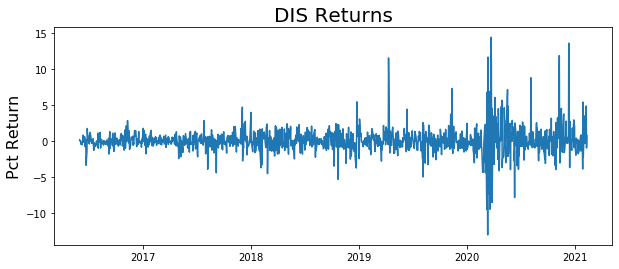

In [288]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Pct Return', fontsize=16)
plt.title('DIS Returns', fontsize=20)

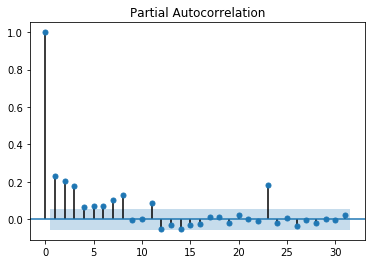

In [290]:
#Plotting Partial Autocorrelation Function for returns^2
# We can see that everything up to lag 8 is significant

plot_pacf(returns**2)
plt.show()

## SVM Classification
### Predicting the direction of change of stock price

In [291]:
tot_length = np.shape(returns)[0]
p = 8

In [292]:
returns_list = returns.tolist()

In [293]:
data_arr = np.zeros(shape = (tot_length - p, p+1))
for i in range(tot_length - p):
    data_arr[i,0:p] = returns_list[i:(i+p)] 
    if returns_list[i+p] > 0:
        data_arr[i,p] = 1
    else:
        data_arr[i,p] = 0

    

In [294]:
data_arr

array([[ 0.20300912,  0.03038774,  0.03037851, ..., -0.51103845,
         0.23628864,  1.        ],
       [ 0.03038774,  0.03037851, -0.43531111, ...,  0.23628864,
         0.85067319,  0.        ],
       [ 0.03037851, -0.43531111, -0.31519834, ...,  0.85067319,
        -0.13211878,  1.        ],
       ...,
       [-3.85114347,  5.42845254, -2.15848651, ...,  2.15383053,
         0.51601174,  1.        ],
       [ 5.42845254, -2.15848651,  1.6649837 , ...,  0.51601174,
         4.87966226,  0.        ],
       [-2.15848651,  1.6649837 ,  3.50354182, ...,  4.87966226,
        -0.94210173,  1.        ]])

In [181]:
# SVM - Rolling Forecast

start_ind = math.floor((tot_length - p)/ 2)
missed = [0] * (tot_length - p - start_ind)

for i in range(start_ind, tot_length - p):
    x_train = data_arr[(i - start_ind):i,0:p]
    y_train = data_arr[(i - start_ind):i,p]
    x_test = data_arr[i:i+1,0:p]
    y_test = data_arr[i,p]
    clf = svm.SVC(kernel = 'linear', C = 5.0, class_weight = 'balanced')
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    missed[i - start_ind] = abs(int(pred) - y_test)

In [182]:
sum(missed) / len(missed)

0.47189097103918226

## Using GARCH model to predict future variability of stock prices

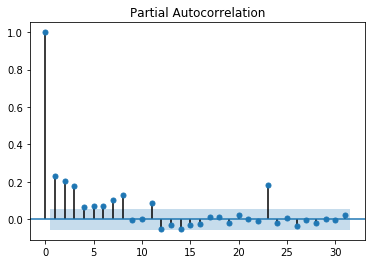

In [295]:
plot_pacf(returns**2)
plt.show()

### GARCH(3,3) Model

In [206]:
model = arch_model(returns, p=3, q=3)

In [207]:
model_fit = model.fit()

Iteration:      1,   Func. Count:     10,   Neg. LLF: 2260.8210434257767
Iteration:      2,   Func. Count:     23,   Neg. LLF: 2259.794461797136
Iteration:      3,   Func. Count:     35,   Neg. LLF: 2257.444954608273
Iteration:      4,   Func. Count:     46,   Neg. LLF: 2251.6653535386295
Iteration:      5,   Func. Count:     57,   Neg. LLF: 2250.860569673194
Iteration:      6,   Func. Count:     68,   Neg. LLF: 2250.248817697414
Iteration:      7,   Func. Count:     79,   Neg. LLF: 2249.967563431556
Iteration:      8,   Func. Count:     90,   Neg. LLF: 2249.824741315467
Iteration:      9,   Func. Count:    101,   Neg. LLF: 2249.6147631406593
Iteration:     10,   Func. Count:    111,   Neg. LLF: 2248.941943306865
Iteration:     11,   Func. Count:    122,   Neg. LLF: 2248.72665829584
Iteration:     12,   Func. Count:    132,   Neg. LLF: 2248.703636677239
Iteration:     13,   Func. Count:    142,   Neg. LLF: 2248.698958314484
Iteration:     14,   Func. Count:    152,   Neg. LLF: 2248.696

In [208]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2248.70
Distribution:                  Normal   AIC:                           4513.39
Method:            Maximum Likelihood   BIC:                           4553.99
                                        No. Observations:                 1182
Date:                Sun, Feb 28 2021   Df Residuals:                     1181
Time:                        23:24:07   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2204  4.574e-02      4.818  1.448e-06 [  0.131,  0.310]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.4766      0.144      3.315  9.169e-04    [  0.195,  0.758]
alpha[1]       0.1059  4.089e-02      2.591  9.566e-03  [2.581e-02,  0.186]
alpha[2]       0.1696  6.312e-02      2.686  7.227e-03  [4.584e-02,  0.293]
alpha[3]       0.1523  8.600e-02      1.771  7.662e-02 [-1.628e-02,  0.321]
beta[1]        0.0000      0.150      0.000      1.000    [ -0.293,  0.293]
beta[2]        0.0000      0.142      0.000      1.000    [ -0.278,  0.278]
beta[3]        0.4499      0.105      4.304  1.678e-05    [  0.245,  0.655]
===========================================================================

Covariance estimator: robust
"""

### Past variance terms turned out to not significant. Therefore we adopt ARCH(3) model.

In [219]:
model = arch_model(returns, p=3, q=0)

In [220]:
model_fit = model.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 2215.451381081064
Iteration:      2,   Func. Count:     17,   Neg. LLF: 2211.0940046218593
Iteration:      3,   Func. Count:     27,   Neg. LLF: 2209.842126055096
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2195.417164914348
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2186.746375156139
Iteration:      6,   Func. Count:     51,   Neg. LLF: 2183.9940522044435
Iteration:      7,   Func. Count:     59,   Neg. LLF: 2178.559288842489
Iteration:      8,   Func. Count:     67,   Neg. LLF: 2178.33392070173
Iteration:      9,   Func. Count:     76,   Neg. LLF: 2176.9243132977276
Iteration:     10,   Func. Count:     83,   Neg. LLF: 2176.759639074204
Iteration:     11,   Func. Count:     90,   Neg. LLF: 2176.7271115212498
Iteration:     12,   Func. Count:     97,   Neg. LLF: 2176.72507898931
Iteration:     13,   Func. Count:    104,   Neg. LLF: 2176.7249808650135
Iteration:     14,   Func. Count:    111,   Neg. LLF: 2176.72

In [213]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -2300.41
Distribution:                  Normal   AIC:                           4610.81
Method:            Maximum Likelihood   BIC:                           4636.19
                                        No. Observations:                 1182
Date:                Sun, Feb 28 2021   Df Residuals:                     1181
Time:                        23:26:31   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1805  4.922e-02      3.667  2.453e-04 [8.403e-02,  0.277]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          1.5585      0.277      5.636  1.742e-08   [  1.017,  2.100]
alpha[1]       0.1421  5.129e-02      2.771  5.590e-03 [4.159e-02,  0.243]
alpha[2]       0.2280  7.064e-02      3.227  1.249e-03 [8.952e-02,  0.366]
alpha[3]       0.2286  9.125e-02      2.506  1.222e-02 [4.980e-02,  0.407]
==========================================================================

Covariance estimator: robust
"""

## Combining GARCH and SVM
### We incorporate the variability predicted by GARCH into SVM to obtain more accurate results 

In [280]:
tot_length = np.shape(returns)[0]
p = 8
vol_len = 100
data_arr = np.zeros(shape = (tot_length - p - vol_len, p + 3))
for i in range(vol_len, tot_length - p - vol_len):
    data_arr[i-vol_len,:p] = returns_list[i:(i+p)]  
    data_arr[i-vol_len,p+1] = np.std(returns[(i-vol_len):i]) #### swap
    
    model = arch_model(returns[(i-vol_len):i], p=3, q=0)
    model_fit = model.fit()
    pred = model_fit.forecast(horizon=1)
    data_arr[i-vol_len,p] = np.sqrt(pred.variance.values[-1,:]) ### swap
    
    if returns_list[i+p] > 0:
        data_arr[i,p+2] = 1
    else:
        data_arr[i,p+2] = 0

    

Iteration:      1,   Func. Count:      7,   Neg. LLF: 109.39826697214323
Iteration:      2,   Func. Count:     17,   Neg. LLF: 107.8000384396379
Iteration:      3,   Func. Count:     27,   Neg. LLF: 105.81112034949585
Iteration:      4,   Func. Count:     35,   Neg. LLF: 105.6962873307007
Iteration:      5,   Func. Count:     43,   Neg. LLF: 105.24164504474074
Iteration:      6,   Func. Count:     51,   Neg. LLF: 105.07323792126435
Iteration:      7,   Func. Count:     59,   Neg. LLF: 105.02532898463211
Iteration:      8,   Func. Count:     66,   Neg. LLF: 104.8126478907025
Iteration:      9,   Func. Count:     73,   Neg. LLF: 104.79926246284789
Iteration:     10,   Func. Count:     80,   Neg. LLF: 104.79529708777734
Iteration:     11,   Func. Count:     87,   Neg. LLF: 104.79522045928061
Iteration:     12,   Func. Count:     94,   Neg. LLF: 104.79521563746063
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 104.79521487744334
            Itera

Iteration:      1,   Func. Count:      7,   Neg. LLF: 115.31382410584409
Iteration:      2,   Func. Count:     18,   Neg. LLF: 112.11556302851076
Iteration:      3,   Func. Count:     28,   Neg. LLF: 111.06301014383922
Iteration:      4,   Func. Count:     36,   Neg. LLF: 111.03221560318758
Iteration:      5,   Func. Count:     44,   Neg. LLF: 110.91954445259033
Iteration:      6,   Func. Count:     52,   Neg. LLF: 110.90866203239742
Iteration:      7,   Func. Count:     60,   Neg. LLF: 110.87129778470845
Iteration:      8,   Func. Count:     68,   Neg. LLF: 110.86982620686757
Iteration:      9,   Func. Count:     75,   Neg. LLF: 110.86871630550621
Iteration:     10,   Func. Count:     82,   Neg. LLF: 110.86836767469778
Iteration:     11,   Func. Count:     89,   Neg. LLF: 110.86835411798731
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 110.86835411800217
            Iterations: 11
            Function evaluations: 89
            Gradient ev

Iteration:      8,   Func. Count:     66,   Neg. LLF: 113.1752302532631
Iteration:      9,   Func. Count:     73,   Neg. LLF: 113.17477032103683
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 113.17477032082945
            Iterations: 9
            Function evaluations: 73
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      7,   Neg. LLF: 116.86573982966009
Iteration:      2,   Func. Count:     17,   Neg. LLF: 115.10538308029899
Iteration:      3,   Func. Count:     27,   Neg. LLF: 112.02716906001652
Iteration:      4,   Func. Count:     34,   Neg. LLF: 110.64097168912201
Iteration:      5,   Func. Count:     42,   Neg. LLF: 110.55435164773161
Iteration:      6,   Func. Count:     51,   Neg. LLF: 110.52883232853013
Iteration:      7,   Func. Count:     58,   Neg. LLF: 110.4621355858469
Iteration:      8,   Func. Count:     65,   Neg. LLF: 110.43558579543682
Iteration:      9,   Func. Count:     72,   Neg. LLF: 110.43084

Iteration:      3,   Func. Count:     28,   Neg. LLF: 110.23921926912418
Iteration:      4,   Func. Count:     36,   Neg. LLF: 110.17239845283231
Iteration:      5,   Func. Count:     43,   Neg. LLF: 109.66899356997712
Iteration:      6,   Func. Count:     52,   Neg. LLF: 109.53363399356228
Iteration:      7,   Func. Count:     61,   Neg. LLF: 109.36563381710904
Iteration:      8,   Func. Count:     68,   Neg. LLF: 109.28957617751354
Iteration:      9,   Func. Count:     75,   Neg. LLF: 109.26579903188153
Iteration:     10,   Func. Count:     82,   Neg. LLF: 109.26415672369542
Iteration:     11,   Func. Count:     89,   Neg. LLF: 109.26385536989912
Iteration:     12,   Func. Count:     96,   Neg. LLF: 109.26382666746001
Iteration:     13,   Func. Count:    103,   Neg. LLF: 109.26382532963461
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 109.26382532969876
            Iterations: 13
            Function evaluations: 103
            Gradient e

Iteration:      1,   Func. Count:      7,   Neg. LLF: 120.47330867404668
Iteration:      2,   Func. Count:     17,   Neg. LLF: 119.00693297179355
Iteration:      3,   Func. Count:     27,   Neg. LLF: 116.21725698036936
Iteration:      4,   Func. Count:     34,   Neg. LLF: 115.44165590238362
Iteration:      5,   Func. Count:     42,   Neg. LLF: 115.34275994196015
Iteration:      6,   Func. Count:     50,   Neg. LLF: 115.14005219618463
Iteration:      7,   Func. Count:     58,   Neg. LLF: 115.04568467271085
Iteration:      8,   Func. Count:     65,   Neg. LLF: 115.01226842680538
Iteration:      9,   Func. Count:     72,   Neg. LLF: 115.01161892407237
Iteration:     10,   Func. Count:     79,   Neg. LLF: 115.01161393059733
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 115.01161393055611
            Iterations: 10
            Function evaluations: 79
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 120.4

Iteration:      1,   Func. Count:      7,   Neg. LLF: 118.99015700994252
Iteration:      2,   Func. Count:     17,   Neg. LLF: 117.18370846168138
Iteration:      3,   Func. Count:     27,   Neg. LLF: 114.68795680497367
Iteration:      4,   Func. Count:     34,   Neg. LLF: 113.66983449636659
Iteration:      5,   Func. Count:     42,   Neg. LLF: 113.6055642321976
Iteration:      6,   Func. Count:     50,   Neg. LLF: 113.47252113312192
Iteration:      7,   Func. Count:     58,   Neg. LLF: 113.35265492373816
Iteration:      8,   Func. Count:     65,   Neg. LLF: 113.31970955923336
Iteration:      9,   Func. Count:     72,   Neg. LLF: 113.31831758540584
Iteration:     10,   Func. Count:     79,   Neg. LLF: 113.31830193888666
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 113.31830193885821
            Iterations: 10
            Function evaluations: 79
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 119.51

Iteration:      1,   Func. Count:      7,   Neg. LLF: 122.45745194006116
Iteration:      2,   Func. Count:     17,   Neg. LLF: 120.55949664831788
Iteration:      3,   Func. Count:     27,   Neg. LLF: 118.23402449391669
Iteration:      4,   Func. Count:     34,   Neg. LLF: 117.13567667181044
Iteration:      5,   Func. Count:     42,   Neg. LLF: 116.78899784307603
Iteration:      6,   Func. Count:     49,   Neg. LLF: 116.71781504103048
Iteration:      7,   Func. Count:     58,   Neg. LLF: 116.7163574840874
Iteration:      8,   Func. Count:     66,   Neg. LLF: 116.70671207724699
Iteration:      9,   Func. Count:     73,   Neg. LLF: 116.70607009072329
Iteration:     10,   Func. Count:     80,   Neg. LLF: 116.70602768704265
Iteration:     11,   Func. Count:     87,   Neg. LLF: 116.70602334500823
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 116.70602334506515
            Iterations: 11
            Function evaluations: 87
            Gradient eva

            Current function value: 120.37057823713607
            Iterations: 9
            Function evaluations: 71
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      7,   Neg. LLF: 127.33425790710794
Iteration:      2,   Func. Count:     18,   Neg. LLF: 122.33217862192275
Iteration:      3,   Func. Count:     28,   Neg. LLF: 121.43419401378273
Iteration:      4,   Func. Count:     35,   Neg. LLF: 120.40625156767278
Iteration:      5,   Func. Count:     43,   Neg. LLF: 120.31161323958099
Iteration:      6,   Func. Count:     50,   Neg. LLF: 120.29964351129226
Iteration:      7,   Func. Count:     57,   Neg. LLF: 120.29473606416045
Iteration:      8,   Func. Count:     64,   Neg. LLF: 120.29464013364908
Iteration:      9,   Func. Count:     71,   Neg. LLF: 120.2946252914524
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 120.29462529147378
            Iterations: 9
            Function evaluations: 71
            Gradi

Iteration:      1,   Func. Count:      7,   Neg. LLF: 125.8999893217251
Iteration:      2,   Func. Count:     17,   Neg. LLF: 123.29084788194096
Iteration:      3,   Func. Count:     27,   Neg. LLF: 121.32103629054433
Iteration:      4,   Func. Count:     34,   Neg. LLF: 118.90817498003054
Iteration:      5,   Func. Count:     42,   Neg. LLF: 118.5220070375725
Iteration:      6,   Func. Count:     49,   Neg. LLF: 118.4117340516829
Iteration:      7,   Func. Count:     56,   Neg. LLF: 118.3367207453872
Iteration:      8,   Func. Count:     63,   Neg. LLF: 118.32819342916765
Iteration:      9,   Func. Count:     70,   Neg. LLF: 118.32785837092133
Iteration:     10,   Func. Count:     77,   Neg. LLF: 118.32785311359736
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 118.32785311360435
            Iterations: 10
            Function evaluations: 77
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 125.89916

Iteration:      9,   Func. Count:     70,   Neg. LLF: 114.73515046001133
Iteration:     10,   Func. Count:     77,   Neg. LLF: 114.73514907179562
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 114.73514907185584
            Iterations: 10
            Function evaluations: 77
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 121.14381416782277
Iteration:      2,   Func. Count:     17,   Neg. LLF: 119.18339269003047
Iteration:      3,   Func. Count:     27,   Neg. LLF: 116.45930858906407
Iteration:      4,   Func. Count:     34,   Neg. LLF: 114.939575139534
Iteration:      5,   Func. Count:     42,   Neg. LLF: 114.59979899597167
Iteration:      6,   Func. Count:     49,   Neg. LLF: 114.50725325733772
Iteration:      7,   Func. Count:     56,   Neg. LLF: 114.49902856965527
Iteration:      8,   Func. Count:     63,   Neg. LLF: 114.49373960026044
Iteration:      9,   Func. Count:     70,   Neg. LLF: 114.493

Iteration:      8,   Func. Count:     63,   Neg. LLF: 114.17476647025363
Iteration:      9,   Func. Count:     70,   Neg. LLF: 114.17467651017354
Iteration:     10,   Func. Count:     77,   Neg. LLF: 114.17467484187542
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 114.17467484191474
            Iterations: 10
            Function evaluations: 77
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 120.74985458187014
Iteration:      2,   Func. Count:     17,   Neg. LLF: 118.63154277968029
Iteration:      3,   Func. Count:     27,   Neg. LLF: 116.32933842756957
Iteration:      4,   Func. Count:     34,   Neg. LLF: 114.74340630567194
Iteration:      5,   Func. Count:     42,   Neg. LLF: 114.36231203253838
Iteration:      6,   Func. Count:     49,   Neg. LLF: 114.2313463156257
Iteration:      7,   Func. Count:     56,   Neg. LLF: 114.22794150263317
Iteration:      8,   Func. Count:     63,   Neg. LLF: 114.22

Iteration:      1,   Func. Count:      7,   Neg. LLF: 117.84164059770104
Iteration:      2,   Func. Count:     17,   Neg. LLF: 115.7472538101886
Iteration:      3,   Func. Count:     27,   Neg. LLF: 113.74941982391712
Iteration:      4,   Func. Count:     34,   Neg. LLF: 112.34291372109485
Iteration:      5,   Func. Count:     42,   Neg. LLF: 111.93984315025533
Iteration:      6,   Func. Count:     49,   Neg. LLF: 111.80059007895181
Iteration:      7,   Func. Count:     56,   Neg. LLF: 111.79416526089474
Iteration:      8,   Func. Count:     63,   Neg. LLF: 111.79161803903372
Iteration:      9,   Func. Count:     70,   Neg. LLF: 111.79130686624528
Iteration:     10,   Func. Count:     77,   Neg. LLF: 111.79130012407637
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 111.79130012411504
            Iterations: 10
            Function evaluations: 77
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 117.32

Iteration:      2,   Func. Count:     17,   Neg. LLF: 98.64483864424508
Iteration:      3,   Func. Count:     27,   Neg. LLF: 96.52768396718348
Iteration:      4,   Func. Count:     35,   Neg. LLF: 95.84755226999654
Iteration:      5,   Func. Count:     43,   Neg. LLF: 95.35898666951111
Iteration:      6,   Func. Count:     51,   Neg. LLF: 94.95959315807738
Iteration:      7,   Func. Count:     58,   Neg. LLF: 94.67793502321496
Iteration:      8,   Func. Count:     65,   Neg. LLF: 94.53302331812488
Iteration:      9,   Func. Count:     72,   Neg. LLF: 94.48692147944556
Iteration:     10,   Func. Count:     79,   Neg. LLF: 94.4844223076265
Iteration:     11,   Func. Count:     86,   Neg. LLF: 94.48437689940552
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 94.48437689944323
            Iterations: 11
            Function evaluations: 86
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      7,   Neg. LLF: 99.29088174291049

Iteration:      5,   Func. Count:     43,   Neg. LLF: 90.82615477438856
Iteration:      6,   Func. Count:     51,   Neg. LLF: 90.21400063080398
Iteration:      7,   Func. Count:     59,   Neg. LLF: 89.2188021317068
Iteration:      8,   Func. Count:     66,   Neg. LLF: 88.86858392172445
Iteration:      9,   Func. Count:     73,   Neg. LLF: 88.85808711265825
Iteration:     10,   Func. Count:     80,   Neg. LLF: 88.85579099863597
Iteration:     11,   Func. Count:     87,   Neg. LLF: 88.85545075048891
Iteration:     12,   Func. Count:     94,   Neg. LLF: 88.85544597796398
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 88.85544597796837
            Iterations: 12
            Function evaluations: 94
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 96.06620231956963
Iteration:      2,   Func. Count:     17,   Neg. LLF: 95.21767445132323
Iteration:      3,   Func. Count:     27,   Neg. LLF: 93.17878114426705

Iteration:     10,   Func. Count:     79,   Neg. LLF: 96.755035929457
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 96.75503495052102
            Iterations: 10
            Function evaluations: 80
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 100.46522298833268
Iteration:      2,   Func. Count:     18,   Neg. LLF: 96.12230961601563
Iteration:      3,   Func. Count:     28,   Neg. LLF: 95.80841291780807
Iteration:      4,   Func. Count:     36,   Neg. LLF: 95.57696132885155
Iteration:      5,   Func. Count:     44,   Neg. LLF: 95.43450885650815
Iteration:      6,   Func. Count:     51,   Neg. LLF: 95.09423154419913
Iteration:      7,   Func. Count:     59,   Neg. LLF: 95.08792947624309
Iteration:      8,   Func. Count:     66,   Neg. LLF: 95.08458415334685
Iteration:      9,   Func. Count:     73,   Neg. LLF: 95.08424527465985
Optimization terminated successfully.    (Exit mode 0)
            Curr

Iteration:      9,   Func. Count:     72,   Neg. LLF: 103.20540602017705
Iteration:     10,   Func. Count:     79,   Neg. LLF: 103.20528510697353
Iteration:     11,   Func. Count:     86,   Neg. LLF: 103.20525934663742
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 103.20525934660938
            Iterations: 11
            Function evaluations: 86
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      7,   Neg. LLF: 109.54546260459142
Iteration:      2,   Func. Count:     18,   Neg. LLF: 104.50055305560343
Iteration:      3,   Func. Count:     28,   Neg. LLF: 104.42028157654643
Iteration:      4,   Func. Count:     36,   Neg. LLF: 104.26189886961187
Iteration:      5,   Func. Count:     44,   Neg. LLF: 104.11250333439648
Iteration:      6,   Func. Count:     51,   Neg. LLF: 103.46514191128439
Iteration:      7,   Func. Count:     59,   Neg. LLF: 103.43634193756911
Iteration:      8,   Func. Count:     66,   Neg. LLF: 103.4

Iteration:      1,   Func. Count:      7,   Neg. LLF: 102.53147481218551
Iteration:      2,   Func. Count:     17,   Neg. LLF: 100.60105352532682
Iteration:      3,   Func. Count:     27,   Neg. LLF: 97.77422439170638
Iteration:      4,   Func. Count:     34,   Neg. LLF: 96.0445502094525
Iteration:      5,   Func. Count:     41,   Neg. LLF: 95.89376406753931
Iteration:      6,   Func. Count:     48,   Neg. LLF: 95.87867938066397
Iteration:      7,   Func. Count:     55,   Neg. LLF: 95.8781274483909
Iteration:      8,   Func. Count:     62,   Neg. LLF: 95.87810617662245
Iteration:      9,   Func. Count:     69,   Neg. LLF: 95.87810502705094
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 95.87810492669601
            Iterations: 9
            Function evaluations: 69
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      7,   Neg. LLF: 104.87106917059954
Iteration:      2,   Func. Count:     17,   Neg. LLF: 103.0774427790289

            Iterations: 18
            Function evaluations: 137
            Gradient evaluations: 18
Iteration:      1,   Func. Count:      7,   Neg. LLF: 105.65523863933944
Iteration:      2,   Func. Count:     17,   Neg. LLF: 104.06429035572327
Iteration:      3,   Func. Count:     27,   Neg. LLF: 101.03761106767728
Iteration:      4,   Func. Count:     35,   Neg. LLF: 100.39359740437722
Iteration:      5,   Func. Count:     43,   Neg. LLF: 100.21636278535419
Iteration:      6,   Func. Count:     51,   Neg. LLF: 99.72340607928678
Iteration:      7,   Func. Count:     59,   Neg. LLF: 99.64879814814394
Iteration:      8,   Func. Count:     66,   Neg. LLF: 99.54465654097828
Iteration:      9,   Func. Count:     73,   Neg. LLF: 99.5287639825749
Iteration:     10,   Func. Count:     80,   Neg. LLF: 99.52659634687589
Iteration:     11,   Func. Count:     87,   Neg. LLF: 99.52305937417798
Iteration:     12,   Func. Count:     95,   Neg. LLF: 99.52286253075265
Iteration:     13,   Func. Cou

Iteration:     11,   Func. Count:     87,   Neg. LLF: 108.62495521339723
Iteration:     12,   Func. Count:     94,   Neg. LLF: 108.62477561817026
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 108.62477556526609
            Iterations: 12
            Function evaluations: 94
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 115.45208782822294
Iteration:      2,   Func. Count:     17,   Neg. LLF: 113.59743618066062
Iteration:      3,   Func. Count:     27,   Neg. LLF: 111.95706134029687
Iteration:      4,   Func. Count:     34,   Neg. LLF: 110.80257856092737
Iteration:      5,   Func. Count:     42,   Neg. LLF: 109.69886398028707
Iteration:      6,   Func. Count:     50,   Neg. LLF: 109.68697141412827
Iteration:      7,   Func. Count:     58,   Neg. LLF: 109.61468431857196
Iteration:      8,   Func. Count:     65,   Neg. LLF: 109.60541786638072
Iteration:      9,   Func. Count:     72,   Neg. LLF: 109.6

Iteration:      1,   Func. Count:      7,   Neg. LLF: 117.25309156122265
Iteration:      2,   Func. Count:     17,   Neg. LLF: 115.32497730563327
Iteration:      3,   Func. Count:     27,   Neg. LLF: 113.56257966056056
Iteration:      4,   Func. Count:     35,   Neg. LLF: 112.7994233800186
Iteration:      5,   Func. Count:     43,   Neg. LLF: 112.291673082039
Iteration:      6,   Func. Count:     51,   Neg. LLF: 111.84854347288521
Iteration:      7,   Func. Count:     59,   Neg. LLF: 111.56219740015439
Iteration:      8,   Func. Count:     67,   Neg. LLF: 111.20437952938279
Iteration:      9,   Func. Count:     75,   Neg. LLF: 111.11633852665831
Iteration:     10,   Func. Count:     83,   Neg. LLF: 111.01498642883378
Iteration:     11,   Func. Count:     90,   Neg. LLF: 110.80700413712032
Iteration:     12,   Func. Count:     98,   Neg. LLF: 110.7948201265865
Iteration:     13,   Func. Count:    105,   Neg. LLF: 110.78103564604689
Iteration:     14,   Func. Count:    112,   Neg. LLF: 1

            Gradient evaluations: 15
Iteration:      1,   Func. Count:      7,   Neg. LLF: 126.48932236566205
Iteration:      2,   Func. Count:     18,   Neg. LLF: 121.63858799373092
Iteration:      3,   Func. Count:     28,   Neg. LLF: 120.35643127336625
Iteration:      4,   Func. Count:     36,   Neg. LLF: 120.19217214845796
Iteration:      5,   Func. Count:     43,   Neg. LLF: 118.99452307051435
Iteration:      6,   Func. Count:     51,   Neg. LLF: 118.92197374145854
Iteration:      7,   Func. Count:     59,   Neg. LLF: 118.84907730780537
Iteration:      8,   Func. Count:     67,   Neg. LLF: 118.71690806474551
Iteration:      9,   Func. Count:     75,   Neg. LLF: 118.53679625645867
Iteration:     10,   Func. Count:     82,   Neg. LLF: 118.19534027363609
Iteration:     11,   Func. Count:     89,   Neg. LLF: 117.79198239256594
Iteration:     12,   Func. Count:     96,   Neg. LLF: 117.7041856892434
Iteration:     13,   Func. Count:    103,   Neg. LLF: 117.70032030117625
Iteration:     

Iteration:      1,   Func. Count:      7,   Neg. LLF: 141.0302873169331
Iteration:      2,   Func. Count:     17,   Neg. LLF: 138.43978455061477
Iteration:      3,   Func. Count:     27,   Neg. LLF: 136.4003236149677
Iteration:      4,   Func. Count:     34,   Neg. LLF: 134.54618275731062
Iteration:      5,   Func. Count:     42,   Neg. LLF: 134.36515218008358
Iteration:      6,   Func. Count:     49,   Neg. LLF: 134.1732087013111
Iteration:      7,   Func. Count:     56,   Neg. LLF: 134.1626599649334
Iteration:      8,   Func. Count:     63,   Neg. LLF: 134.16120031339992
Iteration:      9,   Func. Count:     70,   Neg. LLF: 134.1610977366069
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 134.16109677679742
            Iterations: 9
            Function evaluations: 71
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      7,   Neg. LLF: 141.4656701248848
Iteration:      2,   Func. Count:     17,   Neg. LLF: 138.921434378

Iteration:      1,   Func. Count:      7,   Neg. LLF: 145.3227399142355
Iteration:      2,   Func. Count:     17,   Neg. LLF: 142.38197389639066
Iteration:      3,   Func. Count:     27,   Neg. LLF: 140.45502829858944
Iteration:      4,   Func. Count:     34,   Neg. LLF: 137.9037892951718
Iteration:      5,   Func. Count:     42,   Neg. LLF: 137.77236111021682
Iteration:      6,   Func. Count:     49,   Neg. LLF: 137.42664102616473
Iteration:      7,   Func. Count:     56,   Neg. LLF: 137.3707990050994
Iteration:      8,   Func. Count:     63,   Neg. LLF: 137.36674316089994
Iteration:      9,   Func. Count:     70,   Neg. LLF: 137.36642854521816
Iteration:     10,   Func. Count:     77,   Neg. LLF: 137.36634405841878
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 137.3663439029632
            Iterations: 10
            Function evaluations: 77
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 145.35615

Iteration:      1,   Func. Count:      7,   Neg. LLF: 159.7687383872166
Iteration:      2,   Func. Count:     18,   Neg. LLF: 151.60782876761755
Iteration:      3,   Func. Count:     27,   Neg. LLF: 150.56876875959847
Iteration:      4,   Func. Count:     34,   Neg. LLF: 146.9242766908889
Iteration:      5,   Func. Count:     41,   Neg. LLF: 146.92264269559473
Iteration:      6,   Func. Count:     48,   Neg. LLF: 146.92095624524526
Iteration:      7,   Func. Count:     55,   Neg. LLF: 146.92093394103313
Iteration:      8,   Func. Count:     62,   Neg. LLF: 146.92091496768663
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 146.92091473500534
            Iterations: 8
            Function evaluations: 62
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      7,   Neg. LLF: 159.73178407841033
Iteration:      2,   Func. Count:     18,   Neg. LLF: 151.63784568485923
Iteration:      3,   Func. Count:     27,   Neg. LLF: 150.54480

Iteration:      9,   Func. Count:     69,   Neg. LLF: 144.93421828701392
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 144.93421808761363
            Iterations: 9
            Function evaluations: 69
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      7,   Neg. LLF: 155.50014215838743
Iteration:      2,   Func. Count:     18,   Neg. LLF: 147.23421413313324
Iteration:      3,   Func. Count:     25,   Neg. LLF: 144.02928884256033
Iteration:      4,   Func. Count:     34,   Neg. LLF: 144.02023781390488
Iteration:      5,   Func. Count:     41,   Neg. LLF: 144.01276382273358
Iteration:      6,   Func. Count:     48,   Neg. LLF: 143.98881833750187
Iteration:      7,   Func. Count:     55,   Neg. LLF: 143.98177645358223
Iteration:      8,   Func. Count:     62,   Neg. LLF: 143.98173669448073
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 143.981736507759
            Iterations: 8


Iteration:      7,   Func. Count:     55,   Neg. LLF: 144.70688338396863
Iteration:      8,   Func. Count:     62,   Neg. LLF: 144.7065305414184
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 144.70653036158606
            Iterations: 8
            Function evaluations: 62
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      7,   Neg. LLF: 155.22160804653498
Iteration:      2,   Func. Count:     18,   Neg. LLF: 146.99586385883305
Iteration:      3,   Func. Count:     27,   Neg. LLF: 146.9133515534459
Iteration:      4,   Func. Count:     34,   Neg. LLF: 143.76840557996107
Iteration:      5,   Func. Count:     41,   Neg. LLF: 143.75249704647533
Iteration:      6,   Func. Count:     48,   Neg. LLF: 143.73051867168886
Iteration:      7,   Func. Count:     55,   Neg. LLF: 143.72834429108232
Iteration:      8,   Func. Count:     62,   Neg. LLF: 143.72778032730045
Optimization terminated successfully.    (Exit mode 0)
        

Iteration:      4,   Func. Count:     33,   Neg. LLF: 147.29594835665472
Iteration:      5,   Func. Count:     40,   Neg. LLF: 147.27355978489624
Iteration:      6,   Func. Count:     47,   Neg. LLF: 147.2669699505052
Iteration:      7,   Func. Count:     54,   Neg. LLF: 147.26692791605296
Iteration:      8,   Func. Count:     61,   Neg. LLF: 147.26692639821715
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 147.26692628736666
            Iterations: 8
            Function evaluations: 61
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      7,   Neg. LLF: 158.29665448588568
Iteration:      2,   Func. Count:     18,   Neg. LLF: 150.05876508513413
Iteration:      3,   Func. Count:     27,   Neg. LLF: 149.9662849426856
Iteration:      4,   Func. Count:     34,   Neg. LLF: 147.16858767717653
Iteration:      5,   Func. Count:     41,   Neg. LLF: 147.14811071311948
Iteration:      6,   Func. Count:     48,   Neg. LLF: 147.13144

Iteration:      1,   Func. Count:      7,   Neg. LLF: 155.19800568097978
Iteration:      2,   Func. Count:     18,   Neg. LLF: 146.79313552001213
Iteration:      3,   Func. Count:     27,   Neg. LLF: 146.7036510603146
Iteration:      4,   Func. Count:     34,   Neg. LLF: 143.9529428095646
Iteration:      5,   Func. Count:     41,   Neg. LLF: 143.92235754818856
Iteration:      6,   Func. Count:     48,   Neg. LLF: 143.91601856855766
Iteration:      7,   Func. Count:     55,   Neg. LLF: 143.91598947748423
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 143.91598940739374
            Iterations: 7
            Function evaluations: 55
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      7,   Neg. LLF: 155.26515692902038
Iteration:      2,   Func. Count:     18,   Neg. LLF: 146.82844121787585
Iteration:      3,   Func. Count:     26,   Neg. LLF: 146.72497410467977
Iteration:      4,   Func. Count:     33,   Neg. LLF: 143.90349

Iteration:      1,   Func. Count:      7,   Neg. LLF: 168.1930968447943
Iteration:      2,   Func. Count:     18,   Neg. LLF: 161.86608420924307
Iteration:      3,   Func. Count:     27,   Neg. LLF: 161.58795144773174
Iteration:      4,   Func. Count:     35,   Neg. LLF: 160.6417477946877
Iteration:      5,   Func. Count:     43,   Neg. LLF: 159.9191124665512
Iteration:      6,   Func. Count:     51,   Neg. LLF: 158.8390953486566
Iteration:      7,   Func. Count:     59,   Neg. LLF: 158.74528112796168
Iteration:      8,   Func. Count:     66,   Neg. LLF: 158.00852788125005
Iteration:      9,   Func. Count:     73,   Neg. LLF: 157.96049077372467
Iteration:     10,   Func. Count:     80,   Neg. LLF: 157.93604084237688
Iteration:     11,   Func. Count:     87,   Neg. LLF: 157.9337003252015
Iteration:     12,   Func. Count:     94,   Neg. LLF: 157.9332832957081
Iteration:     13,   Func. Count:    101,   Neg. LLF: 157.93322663549586
Optimization terminated successfully.    (Exit mode 0)
  

Iteration:     11,   Func. Count:     87,   Neg. LLF: 153.67188396759968
Iteration:     12,   Func. Count:     94,   Neg. LLF: 153.6711519095509
Iteration:     13,   Func. Count:    101,   Neg. LLF: 153.67113219563782
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 153.6711314180125
            Iterations: 13
            Function evaluations: 102
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      7,   Neg. LLF: 163.4207774243359
Iteration:      2,   Func. Count:     18,   Neg. LLF: 158.0731281865967
Iteration:      3,   Func. Count:     27,   Neg. LLF: 157.51420009790886
Iteration:      4,   Func. Count:     35,   Neg. LLF: 156.3604351931484
Iteration:      5,   Func. Count:     43,   Neg. LLF: 155.50336734081694
Iteration:      6,   Func. Count:     51,   Neg. LLF: 154.7136429567298
Iteration:      7,   Func. Count:     58,   Neg. LLF: 153.3663912096521
Iteration:      8,   Func. Count:     66,   Neg. LLF: 153.2804304

Iteration:      7,   Func. Count:     58,   Neg. LLF: 157.6280528877158
Iteration:      8,   Func. Count:     65,   Neg. LLF: 157.4583269447654
Iteration:      9,   Func. Count:     72,   Neg. LLF: 157.41490676565365
Iteration:     10,   Func. Count:     79,   Neg. LLF: 157.40436107941113
Iteration:     11,   Func. Count:     86,   Neg. LLF: 157.4031369090158
Iteration:     12,   Func. Count:     93,   Neg. LLF: 157.40244923622538
Iteration:     13,   Func. Count:    100,   Neg. LLF: 157.40242911355654
Iteration:     14,   Func. Count:    107,   Neg. LLF: 157.4024269586477
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 157.40242695865203
            Iterations: 14
            Function evaluations: 107
            Gradient evaluations: 14
Iteration:      1,   Func. Count:      7,   Neg. LLF: 168.35667403570008
Iteration:      2,   Func. Count:     18,   Neg. LLF: 160.43882032753325
Iteration:      3,   Func. Count:     27,   Neg. LLF: 160.2586

Iteration:      6,   Func. Count:     50,   Neg. LLF: 156.0075447266516
Iteration:      7,   Func. Count:     58,   Neg. LLF: 155.95260888373508
Iteration:      8,   Func. Count:     66,   Neg. LLF: 155.67721615109463
Iteration:      9,   Func. Count:     73,   Neg. LLF: 154.84131747313904
Iteration:     10,   Func. Count:     81,   Neg. LLF: 154.70814944822772
Iteration:     11,   Func. Count:     88,   Neg. LLF: 154.59625785145528
Iteration:     12,   Func. Count:     95,   Neg. LLF: 154.56899636731
Iteration:     13,   Func. Count:    102,   Neg. LLF: 154.55715651877242
Iteration:     14,   Func. Count:    109,   Neg. LLF: 154.55253341271577
Iteration:     15,   Func. Count:    116,   Neg. LLF: 154.55056677487585
Iteration:     16,   Func. Count:    123,   Neg. LLF: 154.55034031703502
Iteration:     17,   Func. Count:    130,   Neg. LLF: 154.55032458803268
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 154.55032458798829
            Iterat

Iteration:      1,   Func. Count:      7,   Neg. LLF: 164.30425994130493
Iteration:      2,   Func. Count:     18,   Neg. LLF: 159.77572553232187
Iteration:      3,   Func. Count:     27,   Neg. LLF: 159.32354002154344
Iteration:      4,   Func. Count:     35,   Neg. LLF: 158.27340753015736
Iteration:      5,   Func. Count:     43,   Neg. LLF: 157.4233599495306
Iteration:      6,   Func. Count:     51,   Neg. LLF: 156.88108936035854
Iteration:      7,   Func. Count:     58,   Neg. LLF: 155.70510408732255
Iteration:      8,   Func. Count:     65,   Neg. LLF: 155.4454449542426
Iteration:      9,   Func. Count:     73,   Neg. LLF: 155.35962051047426
Iteration:     10,   Func. Count:     80,   Neg. LLF: 155.30781765243648
Iteration:     11,   Func. Count:     87,   Neg. LLF: 155.29687352203163
Iteration:     12,   Func. Count:     94,   Neg. LLF: 155.29472666163085
Iteration:     13,   Func. Count:    101,   Neg. LLF: 155.29472162204834
Optimization terminated successfully.    (Exit mode 0

Iteration:      2,   Func. Count:     18,   Neg. LLF: 163.68623945229973
Iteration:      3,   Func. Count:     27,   Neg. LLF: 163.16882028166
Iteration:      4,   Func. Count:     35,   Neg. LLF: 162.18097440651363
Iteration:      5,   Func. Count:     43,   Neg. LLF: 161.68193875378543
Iteration:      6,   Func. Count:     51,   Neg. LLF: 161.20584968141281
Iteration:      7,   Func. Count:     58,   Neg. LLF: 160.10327438490935
Iteration:      8,   Func. Count:     65,   Neg. LLF: 159.81351847892222
Iteration:      9,   Func. Count:     72,   Neg. LLF: 159.72045171602542
Iteration:     10,   Func. Count:     79,   Neg. LLF: 159.68655544898027
Iteration:     11,   Func. Count:     86,   Neg. LLF: 159.68503478182507
Iteration:     12,   Func. Count:     93,   Neg. LLF: 159.68470405578287
Iteration:     13,   Func. Count:    100,   Neg. LLF: 159.6846969236659
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 159.68469641477748
            Iterat

Iteration:      1,   Func. Count:      7,   Neg. LLF: 176.32387538117243
Iteration:      2,   Func. Count:     18,   Neg. LLF: 172.40426835847924
Iteration:      3,   Func. Count:     27,   Neg. LLF: 172.10989596839994
Iteration:      4,   Func. Count:     35,   Neg. LLF: 171.6959224604763
Iteration:      5,   Func. Count:     43,   Neg. LLF: 171.2180746699018
Iteration:      6,   Func. Count:     50,   Neg. LLF: 170.04642229914816
Iteration:      7,   Func. Count:     57,   Neg. LLF: 169.9545455634837
Iteration:      8,   Func. Count:     64,   Neg. LLF: 169.93606707714576
Iteration:      9,   Func. Count:     71,   Neg. LLF: 169.9266148259336
Iteration:     10,   Func. Count:     78,   Neg. LLF: 169.92565332887148
Iteration:     11,   Func. Count:     85,   Neg. LLF: 169.92553967255978
Iteration:     12,   Func. Count:     92,   Neg. LLF: 169.92553723305116
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 169.9255372330355
            Iterati

Iteration:      1,   Func. Count:      7,   Neg. LLF: 177.150257626513
Iteration:      2,   Func. Count:     18,   Neg. LLF: 173.03709833232912
Iteration:      3,   Func. Count:     27,   Neg. LLF: 172.80581085669758
Iteration:      4,   Func. Count:     35,   Neg. LLF: 172.51584900862835
Iteration:      5,   Func. Count:     43,   Neg. LLF: 172.17418477794564
Iteration:      6,   Func. Count:     50,   Neg. LLF: 171.21380382845723
Iteration:      7,   Func. Count:     57,   Neg. LLF: 171.20818210162815
Iteration:      8,   Func. Count:     64,   Neg. LLF: 171.2069049916251
Iteration:      9,   Func. Count:     71,   Neg. LLF: 171.20681162891165
Iteration:     10,   Func. Count:     78,   Neg. LLF: 171.20678084993645
Iteration:     11,   Func. Count:     85,   Neg. LLF: 171.20677891288926
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 171.20677891290904
            Iterations: 11
            Function evaluations: 85
            Gradient evalu

Iteration:      2,   Func. Count:     18,   Neg. LLF: 177.30129933486523
Iteration:      3,   Func. Count:     27,   Neg. LLF: 177.17184306900452
Iteration:      4,   Func. Count:     35,   Neg. LLF: 176.96110270986907
Iteration:      5,   Func. Count:     43,   Neg. LLF: 176.85113042328462
Iteration:      6,   Func. Count:     50,   Neg. LLF: 176.00654044647646
Iteration:      7,   Func. Count:     57,   Neg. LLF: 175.99549122541046
Iteration:      8,   Func. Count:     64,   Neg. LLF: 175.99357569228647
Iteration:      9,   Func. Count:     71,   Neg. LLF: 175.9928523005707
Iteration:     10,   Func. Count:     78,   Neg. LLF: 175.99249700384212
Iteration:     11,   Func. Count:     85,   Neg. LLF: 175.99245305687242
Iteration:     12,   Func. Count:     92,   Neg. LLF: 175.99245133785544
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 175.99245133786687
            Iterations: 12
            Function evaluations: 92
            Gradient eva

Iteration:      3,   Func. Count:     27,   Neg. LLF: 177.248044961148
Iteration:      4,   Func. Count:     35,   Neg. LLF: 177.07769799389277
Iteration:      5,   Func. Count:     43,   Neg. LLF: 176.9504291715699
Iteration:      6,   Func. Count:     50,   Neg. LLF: 176.10256526747716
Iteration:      7,   Func. Count:     57,   Neg. LLF: 176.09460203490644
Iteration:      8,   Func. Count:     64,   Neg. LLF: 176.09048505400975
Iteration:      9,   Func. Count:     71,   Neg. LLF: 176.08619733767446
Iteration:     10,   Func. Count:     78,   Neg. LLF: 176.08599554097594
Iteration:     11,   Func. Count:     85,   Neg. LLF: 176.0859892314802
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 176.0859892314941
            Iterations: 11
            Function evaluations: 85
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      7,   Neg. LLF: 182.0730385888731
Iteration:      2,   Func. Count:     18,   Neg. LLF: 177.4292901

Iteration:      1,   Func. Count:      7,   Neg. LLF: 183.0568745099477
Iteration:      2,   Func. Count:     17,   Neg. LLF: 180.6275613316013
Iteration:      3,   Func. Count:     26,   Neg. LLF: 180.30480262346214
Iteration:      4,   Func. Count:     34,   Neg. LLF: 180.0724560197125
Iteration:      5,   Func. Count:     41,   Neg. LLF: 178.2857594809446
Iteration:      6,   Func. Count:     49,   Neg. LLF: 178.18563894530317
Iteration:      7,   Func. Count:     57,   Neg. LLF: 178.07951560035963
Iteration:      8,   Func. Count:     65,   Neg. LLF: 178.06757651672527
Iteration:      9,   Func. Count:     72,   Neg. LLF: 178.06617855042398
Iteration:     10,   Func. Count:     79,   Neg. LLF: 178.06599933911542
Iteration:     11,   Func. Count:     86,   Neg. LLF: 178.06599828134745
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 178.06599828135765
            Iterations: 11
            Function evaluations: 86
            Gradient evalua

Iteration:      2,   Func. Count:     18,   Neg. LLF: 170.8314903421337
Iteration:      3,   Func. Count:     27,   Neg. LLF: 170.45617979288056
Iteration:      4,   Func. Count:     35,   Neg. LLF: 170.01251927984634
Iteration:      5,   Func. Count:     42,   Neg. LLF: 168.94921467090396
Iteration:      6,   Func. Count:     49,   Neg. LLF: 168.94109687705335
Iteration:      7,   Func. Count:     56,   Neg. LLF: 168.93659666503942
Iteration:      8,   Func. Count:     64,   Neg. LLF: 168.93584814413902
Iteration:      9,   Func. Count:     71,   Neg. LLF: 168.93580504032664
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 168.93580501410662
            Iterations: 9
            Function evaluations: 71
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      7,   Neg. LLF: 175.3425233404226
Iteration:      2,   Func. Count:     18,   Neg. LLF: 170.7358247687267
Iteration:      3,   Func. Count:     27,   Neg. LLF: 170.317275

Iteration:      1,   Func. Count:      7,   Neg. LLF: 170.59741850914511
Iteration:      2,   Func. Count:     18,   Neg. LLF: 166.80347653758903
Iteration:      3,   Func. Count:     27,   Neg. LLF: 166.44208983140902
Iteration:      4,   Func. Count:     35,   Neg. LLF: 165.65182300749103
Iteration:      5,   Func. Count:     42,   Neg. LLF: 164.8794856065944
Iteration:      6,   Func. Count:     50,   Neg. LLF: 164.81363947761218
Iteration:      7,   Func. Count:     58,   Neg. LLF: 164.69407138434454
Iteration:      8,   Func. Count:     65,   Neg. LLF: 164.66423711657492
Iteration:      9,   Func. Count:     72,   Neg. LLF: 164.6512294974402
Iteration:     10,   Func. Count:     79,   Neg. LLF: 164.6505898059613
Iteration:     11,   Func. Count:     86,   Neg. LLF: 164.6505543146394
Iteration:     12,   Func. Count:     93,   Neg. LLF: 164.65055326916155
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 164.6505532691749
            Iterati

Iteration:      1,   Func. Count:      7,   Neg. LLF: 170.32324234692513
Iteration:      2,   Func. Count:     18,   Neg. LLF: 166.55555141921678
Iteration:      3,   Func. Count:     27,   Neg. LLF: 166.20639397818167
Iteration:      4,   Func. Count:     35,   Neg. LLF: 165.53133048849242
Iteration:      5,   Func. Count:     42,   Neg. LLF: 164.81326060956374
Iteration:      6,   Func. Count:     51,   Neg. LLF: 164.791351907041
Iteration:      7,   Func. Count:     58,   Neg. LLF: 164.74309989500296
Iteration:      8,   Func. Count:     65,   Neg. LLF: 164.72108952640747
Iteration:      9,   Func. Count:     72,   Neg. LLF: 164.71338451171601
Iteration:     10,   Func. Count:     79,   Neg. LLF: 164.7129275114619
Iteration:     11,   Func. Count:     86,   Neg. LLF: 164.71291359012162
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 164.71291359010652
            Iterations: 11
            Function evaluations: 86
            Gradient evalu

Iteration:      3,   Func. Count:     27,   Neg. LLF: 168.56707638465355
Iteration:      4,   Func. Count:     35,   Neg. LLF: 168.08132664211487
Iteration:      5,   Func. Count:     42,   Neg. LLF: 167.73877278386038
Iteration:      6,   Func. Count:     51,   Neg. LLF: 167.69888203065383
Iteration:      7,   Func. Count:     58,   Neg. LLF: 167.63519232004282
Iteration:      8,   Func. Count:     65,   Neg. LLF: 167.5972064918173
Iteration:      9,   Func. Count:     72,   Neg. LLF: 167.59629924333348
Iteration:     10,   Func. Count:     79,   Neg. LLF: 167.5962883454425
Iteration:     11,   Func. Count:     86,   Neg. LLF: 167.59628714052116
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 167.59628714053025
            Iterations: 11
            Function evaluations: 86
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      7,   Neg. LLF: 171.7754652782192
Iteration:      2,   Func. Count:     18,   Neg. LLF: 168.0038

Iteration:      3,   Func. Count:     26,   Neg. LLF: 162.047847316354
Iteration:      4,   Func. Count:     35,   Neg. LLF: 162.00692124726945
Iteration:      5,   Func. Count:     42,   Neg. LLF: 160.90665640314327
Iteration:      6,   Func. Count:     49,   Neg. LLF: 160.88256414268096
Iteration:      7,   Func. Count:     56,   Neg. LLF: 160.88157372216082
Iteration:      8,   Func. Count:     63,   Neg. LLF: 160.88157177165294
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 160.88157158358453
            Iterations: 8
            Function evaluations: 63
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      7,   Neg. LLF: 166.79141047274462
Iteration:      2,   Func. Count:     18,   Neg. LLF: 162.11300218914545
Iteration:      3,   Func. Count:     27,   Neg. LLF: 161.93640359106257
Iteration:      4,   Func. Count:     35,   Neg. LLF: 161.762248531505
Iteration:      5,   Func. Count:     42,   Neg. LLF: 160.7430154

Iteration:      1,   Func. Count:      7,   Neg. LLF: 157.71332260555099
Iteration:      2,   Func. Count:     18,   Neg. LLF: 152.88968599151687
Iteration:      3,   Func. Count:     27,   Neg. LLF: 152.18053629818326
Iteration:      4,   Func. Count:     34,   Neg. LLF: 151.01133258348787
Iteration:      5,   Func. Count:     41,   Neg. LLF: 150.99569813336566
Iteration:      6,   Func. Count:     49,   Neg. LLF: 150.9891232553096
Iteration:      7,   Func. Count:     56,   Neg. LLF: 150.98715150498364
Iteration:      8,   Func. Count:     63,   Neg. LLF: 150.98712640154508
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 150.98712634952346
            Iterations: 8
            Function evaluations: 63
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      7,   Neg. LLF: 158.64301380434748
Iteration:      2,   Func. Count:     18,   Neg. LLF: 153.90664063923052
Iteration:      3,   Func. Count:     27,   Neg. LLF: 153.1136

Iteration:      8,   Func. Count:     63,   Neg. LLF: 147.14740808547015
Iteration:      9,   Func. Count:     70,   Neg. LLF: 147.14739009183972
Iteration:     10,   Func. Count:     77,   Neg. LLF: 147.1473882115012
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 147.14738810980643
            Iterations: 10
            Function evaluations: 77
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 152.7982211992693
Iteration:      2,   Func. Count:     18,   Neg. LLF: 147.6832804178202
Iteration:      3,   Func. Count:     28,   Neg. LLF: 147.01943964433798
Iteration:      4,   Func. Count:     35,   Neg. LLF: 145.7012095549037
Iteration:      5,   Func. Count:     42,   Neg. LLF: 145.66508737146486
Iteration:      6,   Func. Count:     49,   Neg. LLF: 145.651242286909
Iteration:      7,   Func. Count:     56,   Neg. LLF: 145.65063929954164
Iteration:      8,   Func. Count:     63,   Neg. LLF: 145.6506247

Iteration:      1,   Func. Count:      7,   Neg. LLF: 146.42061154384464
Iteration:      2,   Func. Count:     18,   Neg. LLF: 141.5576407440944
Iteration:      3,   Func. Count:     27,   Neg. LLF: 141.22009391322104
Iteration:      4,   Func. Count:     34,   Neg. LLF: 140.3884780701149
Iteration:      5,   Func. Count:     42,   Neg. LLF: 140.29623105614354
Iteration:      6,   Func. Count:     50,   Neg. LLF: 140.2734201487679
Iteration:      7,   Func. Count:     57,   Neg. LLF: 140.2733536703929
Iteration:      8,   Func. Count:     64,   Neg. LLF: 140.27333515318927
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 140.2733351096034
            Iterations: 8
            Function evaluations: 64
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      7,   Neg. LLF: 145.8607726927749
Iteration:      2,   Func. Count:     18,   Neg. LLF: 141.04690431344645
Iteration:      3,   Func. Count:     27,   Neg. LLF: 140.725543092

Iteration:      1,   Func. Count:      7,   Neg. LLF: 145.6567641774976
Iteration:      2,   Func. Count:     18,   Neg. LLF: 140.2657030639977
Iteration:      3,   Func. Count:     27,   Neg. LLF: 140.2095621154006
Iteration:      4,   Func. Count:     35,   Neg. LLF: 140.11613523367868
Iteration:      5,   Func. Count:     42,   Neg. LLF: 138.77086777677349
Iteration:      6,   Func. Count:     49,   Neg. LLF: 138.7428771720714
Iteration:      7,   Func. Count:     56,   Neg. LLF: 138.73874786132015
Iteration:      8,   Func. Count:     63,   Neg. LLF: 138.73866004533332
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 138.7386598813281
            Iterations: 8
            Function evaluations: 63
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      7,   Neg. LLF: 145.3588575565722
Iteration:      2,   Func. Count:     18,   Neg. LLF: 140.06837978867782
Iteration:      3,   Func. Count:     27,   Neg. LLF: 140.015755054

Iteration:      1,   Func. Count:      7,   Neg. LLF: 149.71148376691596
Iteration:      2,   Func. Count:     18,   Neg. LLF: 144.91520260578613
Iteration:      3,   Func. Count:     26,   Neg. LLF: 144.84796289936526
Iteration:      4,   Func. Count:     34,   Neg. LLF: 144.45786589897222
Iteration:      5,   Func. Count:     41,   Neg. LLF: 143.85511757170494
Iteration:      6,   Func. Count:     49,   Neg. LLF: 143.84368426050972
Iteration:      7,   Func. Count:     58,   Neg. LLF: 143.84190793050703
Iteration:      8,   Func. Count:     65,   Neg. LLF: 143.84049648399628
Iteration:      9,   Func. Count:     72,   Neg. LLF: 143.8401331783222
Iteration:     10,   Func. Count:     79,   Neg. LLF: 143.84011171564893
Iteration:     11,   Func. Count:     86,   Neg. LLF: 143.8401085323903
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 143.8401084509077
            Iterations: 11
            Function evaluations: 86
            Gradient evalu

            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 160.49725367613723
Iteration:      2,   Func. Count:     18,   Neg. LLF: 156.16606785105088
Iteration:      3,   Func. Count:     27,   Neg. LLF: 155.5170156150656
Iteration:      4,   Func. Count:     35,   Neg. LLF: 154.07596488276428
Iteration:      5,   Func. Count:     43,   Neg. LLF: 153.42963245802522
Iteration:      6,   Func. Count:     51,   Neg. LLF: 152.66760503649397
Iteration:      7,   Func. Count:     59,   Neg. LLF: 151.76706999975684
Iteration:      8,   Func. Count:     67,   Neg. LLF: 151.59235725930014
Iteration:      9,   Func. Count:     74,   Neg. LLF: 151.3874902688592
Iteration:     10,   Func. Count:     83,   Neg. LLF: 151.26259970751548
Iteration:     11,   Func. Count:     90,   Neg. LLF: 151.15883933173473
Iteration:     12,   Func. Count:     97,   Neg. LLF: 151.12221194762597
Iteration:     13,   Func. Count:    104,   Neg. LLF: 151.12081413814025
Iteration:     1

Iteration:     10,   Func. Count:     83,   Neg. LLF: 149.39920894212057
Iteration:     11,   Func. Count:     91,   Neg. LLF: 149.3874790552408
Iteration:     12,   Func. Count:     99,   Neg. LLF: 149.38493991987164
Iteration:     13,   Func. Count:    106,   Neg. LLF: 149.38449946820288
Iteration:     14,   Func. Count:    113,   Neg. LLF: 149.38444686991886
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 149.38444588136122
            Iterations: 14
            Function evaluations: 114
            Gradient evaluations: 14
Iteration:      1,   Func. Count:      7,   Neg. LLF: 158.2351758074752
Iteration:      2,   Func. Count:     18,   Neg. LLF: 154.7067646361357
Iteration:      3,   Func. Count:     27,   Neg. LLF: 154.05533107606098
Iteration:      4,   Func. Count:     35,   Neg. LLF: 152.69990441796497
Iteration:      5,   Func. Count:     43,   Neg. LLF: 152.096030265508
Iteration:      6,   Func. Count:     51,   Neg. LLF: 151.46800

Iteration:      1,   Func. Count:      7,   Neg. LLF: 156.03206246095183
Iteration:      2,   Func. Count:     18,   Neg. LLF: 152.59323820284214
Iteration:      3,   Func. Count:     27,   Neg. LLF: 151.94117434717194
Iteration:      4,   Func. Count:     35,   Neg. LLF: 150.51057036924777
Iteration:      5,   Func. Count:     43,   Neg. LLF: 149.93097730573137
Iteration:      6,   Func. Count:     51,   Neg. LLF: 149.1184468327543
Iteration:      7,   Func. Count:     58,   Neg. LLF: 148.46836020096097
Iteration:      8,   Func. Count:     66,   Neg. LLF: 148.14425726345092
Iteration:      9,   Func. Count:     75,   Neg. LLF: 147.84626203761704
Iteration:     10,   Func. Count:     83,   Neg. LLF: 147.7430371669823
Iteration:     11,   Func. Count:     91,   Neg. LLF: 147.61019975309225
Iteration:     12,   Func. Count:     98,   Neg. LLF: 147.58606943464778
Iteration:     13,   Func. Count:    105,   Neg. LLF: 147.5651553266532
Iteration:     14,   Func. Count:    112,   Neg. LLF: 

Iteration:     12,   Func. Count:     97,   Neg. LLF: 154.5676600299912
Iteration:     13,   Func. Count:    104,   Neg. LLF: 154.56708913882997
Iteration:     14,   Func. Count:    111,   Neg. LLF: 154.56703683943064
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 154.56703683943957
            Iterations: 14
            Function evaluations: 111
            Gradient evaluations: 14
Iteration:      1,   Func. Count:      7,   Neg. LLF: 161.65183266341887
Iteration:      2,   Func. Count:     18,   Neg. LLF: 157.4764134295178
Iteration:      3,   Func. Count:     27,   Neg. LLF: 156.95986065484513
Iteration:      4,   Func. Count:     35,   Neg. LLF: 155.87631750606295
Iteration:      5,   Func. Count:     43,   Neg. LLF: 155.2100027961028
Iteration:      6,   Func. Count:     51,   Neg. LLF: 155.0850142396972
Iteration:      7,   Func. Count:     58,   Neg. LLF: 154.8833125640419
Iteration:      8,   Func. Count:     66,   Neg. LLF: 154.82757

Iteration:      9,   Func. Count:     74,   Neg. LLF: 158.96527141325095
Iteration:     10,   Func. Count:     82,   Neg. LLF: 158.9517717611247
Iteration:     11,   Func. Count:     89,   Neg. LLF: 158.94855750452294
Iteration:     12,   Func. Count:     96,   Neg. LLF: 158.94844601158692
Iteration:     13,   Func. Count:    103,   Neg. LLF: 158.94844429784035
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 158.94844429785027
            Iterations: 13
            Function evaluations: 103
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      7,   Neg. LLF: 165.65713437630797
Iteration:      2,   Func. Count:     18,   Neg. LLF: 161.31057704166827
Iteration:      3,   Func. Count:     27,   Neg. LLF: 160.84067383486405
Iteration:      4,   Func. Count:     35,   Neg. LLF: 159.99426124075543
Iteration:      5,   Func. Count:     43,   Neg. LLF: 159.70441783484415
Iteration:      6,   Func. Count:     51,   Neg. LLF: 159.5

Iteration:      6,   Func. Count:     51,   Neg. LLF: 161.9203689070781
Iteration:      7,   Func. Count:     58,   Neg. LLF: 161.84393870772723
Iteration:      8,   Func. Count:     66,   Neg. LLF: 161.83054266230948
Iteration:      9,   Func. Count:     73,   Neg. LLF: 161.80138506023695
Iteration:     10,   Func. Count:     80,   Neg. LLF: 161.796646181374
Iteration:     11,   Func. Count:     87,   Neg. LLF: 161.79649934877975
Iteration:     12,   Func. Count:     94,   Neg. LLF: 161.7964969114229
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 161.7964969114463
            Iterations: 12
            Function evaluations: 94
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 170.84444815940958
Iteration:      2,   Func. Count:     18,   Neg. LLF: 166.95963314499178
Iteration:      3,   Func. Count:     27,   Neg. LLF: 166.61650884150998
Iteration:      4,   Func. Count:     35,   Neg. LLF: 165.948378

Iteration:     10,   Func. Count:     80,   Neg. LLF: 171.82166012867404
Iteration:     11,   Func. Count:     87,   Neg. LLF: 171.7979606805233
Iteration:     12,   Func. Count:     94,   Neg. LLF: 171.79283233185748
Iteration:     13,   Func. Count:    101,   Neg. LLF: 171.78870300158763
Iteration:     14,   Func. Count:    108,   Neg. LLF: 171.78868890232803
Iteration:     15,   Func. Count:    115,   Neg. LLF: 171.78868579189754
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 171.788685791897
            Iterations: 15
            Function evaluations: 115
            Gradient evaluations: 15
Iteration:      1,   Func. Count:      7,   Neg. LLF: 178.32158001356376
Iteration:      2,   Func. Count:     17,   Neg. LLF: 176.01210063570875
Iteration:      3,   Func. Count:     26,   Neg. LLF: 175.5186054049963
Iteration:      4,   Func. Count:     34,   Neg. LLF: 174.56224521049646
Iteration:      5,   Func. Count:     42,   Neg. LLF: 173.7257

Iteration:      6,   Func. Count:     50,   Neg. LLF: 174.39671234921477
Iteration:      7,   Func. Count:     57,   Neg. LLF: 174.29334424911977
Iteration:      8,   Func. Count:     64,   Neg. LLF: 174.27387772994246
Iteration:      9,   Func. Count:     71,   Neg. LLF: 174.2706701789221
Iteration:     10,   Func. Count:     78,   Neg. LLF: 174.26969795378142
Iteration:     11,   Func. Count:     85,   Neg. LLF: 174.2696624811956
Iteration:     12,   Func. Count:     92,   Neg. LLF: 174.26965973423705
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 174.26965973421284
            Iterations: 12
            Function evaluations: 92
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 179.26794912857147
Iteration:      2,   Func. Count:     17,   Neg. LLF: 176.89556758992654
Iteration:      3,   Func. Count:     26,   Neg. LLF: 176.42387477035192
Iteration:      4,   Func. Count:     34,   Neg. LLF: 175.751

Iteration:      1,   Func. Count:      7,   Neg. LLF: 179.40733028953943
Iteration:      2,   Func. Count:     17,   Neg. LLF: 177.0372442920059
Iteration:      3,   Func. Count:     26,   Neg. LLF: 176.645553259453
Iteration:      4,   Func. Count:     34,   Neg. LLF: 175.89583778340247
Iteration:      5,   Func. Count:     42,   Neg. LLF: 175.18120308738227
Iteration:      6,   Func. Count:     50,   Neg. LLF: 174.50588526580196
Iteration:      7,   Func. Count:     57,   Neg. LLF: 174.42918839636866
Iteration:      8,   Func. Count:     64,   Neg. LLF: 174.40870566449493
Iteration:      9,   Func. Count:     71,   Neg. LLF: 174.40575741322147
Iteration:     10,   Func. Count:     78,   Neg. LLF: 174.4042879304181
Iteration:     11,   Func. Count:     85,   Neg. LLF: 174.4042756913466
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 174.40427496315263
            Iterations: 11
            Function evaluations: 86
            Gradient evaluat

Iteration:      1,   Func. Count:      7,   Neg. LLF: 178.78159372376408
Iteration:      2,   Func. Count:     17,   Neg. LLF: 176.51643740658523
Iteration:      3,   Func. Count:     26,   Neg. LLF: 176.0099224895303
Iteration:      4,   Func. Count:     34,   Neg. LLF: 175.27277085736068
Iteration:      5,   Func. Count:     42,   Neg. LLF: 174.49882945376626
Iteration:      6,   Func. Count:     50,   Neg. LLF: 173.73503319599462
Iteration:      7,   Func. Count:     57,   Neg. LLF: 173.52661287792577
Iteration:      8,   Func. Count:     64,   Neg. LLF: 173.4778103900155
Iteration:      9,   Func. Count:     71,   Neg. LLF: 173.47040493114463
Iteration:     10,   Func. Count:     78,   Neg. LLF: 173.467404158162
Iteration:     11,   Func. Count:     85,   Neg. LLF: 173.4671350402268
Iteration:     12,   Func. Count:     92,   Neg. LLF: 173.4671320369092
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 173.46713203690382
            Iteratio

            Function evaluations: 106
            Gradient evaluations: 14
Iteration:      1,   Func. Count:      7,   Neg. LLF: 176.63880357710792
Iteration:      2,   Func. Count:     17,   Neg. LLF: 174.5761117444177
Iteration:      3,   Func. Count:     26,   Neg. LLF: 174.0286313215204
Iteration:      4,   Func. Count:     34,   Neg. LLF: 173.27286784205094
Iteration:      5,   Func. Count:     42,   Neg. LLF: 172.33821407749173
Iteration:      6,   Func. Count:     50,   Neg. LLF: 171.8796304539325
Iteration:      7,   Func. Count:     58,   Neg. LLF: 171.03512886182975
Iteration:      8,   Func. Count:     65,   Neg. LLF: 170.93645009041703
Iteration:      9,   Func. Count:     73,   Neg. LLF: 170.93085428737152
Iteration:     10,   Func. Count:     80,   Neg. LLF: 170.92083392249748
Iteration:     11,   Func. Count:     87,   Neg. LLF: 170.89954092187386
Iteration:     12,   Func. Count:     94,   Neg. LLF: 170.8991351275543
Iteration:     13,   Func. Count:    101,   Neg. LLF:

Iteration:      2,   Func. Count:     17,   Neg. LLF: 168.32711554632573
Iteration:      3,   Func. Count:     25,   Neg. LLF: 167.10634215545196
Iteration:      4,   Func. Count:     34,   Neg. LLF: 166.80554952594827
Iteration:      5,   Func. Count:     42,   Neg. LLF: 166.1473195845013
Iteration:      6,   Func. Count:     50,   Neg. LLF: 165.5125164568051
Iteration:      7,   Func. Count:     58,   Neg. LLF: 165.10064228096127
Iteration:      8,   Func. Count:     65,   Neg. LLF: 165.0060812921471
Iteration:      9,   Func. Count:     72,   Neg. LLF: 165.0042221645317
Iteration:     10,   Func. Count:     79,   Neg. LLF: 165.0039492836857
Iteration:     11,   Func. Count:     86,   Neg. LLF: 165.003896091797
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 165.00389609177927
            Iterations: 11
            Function evaluations: 86
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      7,   Neg. LLF: 170.82341254

            Current function value: 156.04125446057972
            Iterations: 13
            Function evaluations: 104
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      7,   Neg. LLF: 161.23425983494303
Iteration:      2,   Func. Count:     18,   Neg. LLF: 159.13291158948223
Iteration:      3,   Func. Count:     26,   Neg. LLF: 158.71780698246872
Iteration:      4,   Func. Count:     34,   Neg. LLF: 157.01266135486122
Iteration:      5,   Func. Count:     42,   Neg. LLF: 156.12419073025896
Iteration:      6,   Func. Count:     50,   Neg. LLF: 155.77574894503923
Iteration:      7,   Func. Count:     59,   Neg. LLF: 155.763102188669
Iteration:      8,   Func. Count:     66,   Neg. LLF: 155.660414302167
Iteration:      9,   Func. Count:     75,   Neg. LLF: 155.65718016899035
Iteration:     10,   Func. Count:     82,   Neg. LLF: 155.55812799705046
Iteration:     11,   Func. Count:     89,   Neg. LLF: 155.51665656252572
Iteration:     12,   Func. Count:     96,   

            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 162.46539916992947
Iteration:      2,   Func. Count:     18,   Neg. LLF: 160.29442570084402
Iteration:      3,   Func. Count:     27,   Neg. LLF: 159.72037438325475
Iteration:      4,   Func. Count:     35,   Neg. LLF: 158.47732303087298
Iteration:      5,   Func. Count:     43,   Neg. LLF: 157.9164829023406
Iteration:      6,   Func. Count:     52,   Neg. LLF: 157.83881366597333
Iteration:      7,   Func. Count:     60,   Neg. LLF: 157.7106934801887
Iteration:      8,   Func. Count:     67,   Neg. LLF: 157.53601421849302
Iteration:      9,   Func. Count:     74,   Neg. LLF: 157.5064102352701
Iteration:     10,   Func. Count:     81,   Neg. LLF: 157.50421162039092
Iteration:     11,   Func. Count:     88,   Neg. LLF: 157.5040502810544
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 157.50404937988435
            Iterations: 11
            Function evalua

Iteration:      1,   Func. Count:      7,   Neg. LLF: 201.34637277820735
Iteration:      2,   Func. Count:     17,   Neg. LLF: 195.47122845169753
Iteration:      3,   Func. Count:     26,   Neg. LLF: 195.0205733506891
Iteration:      4,   Func. Count:     33,   Neg. LLF: 185.63508797622126
Iteration:      5,   Func. Count:     40,   Neg. LLF: 184.122175707007
Iteration:      6,   Func. Count:     51,   Neg. LLF: 184.11718709684146
Iteration:      7,   Func. Count:     60,   Neg. LLF: 183.5707002591102
Iteration:      8,   Func. Count:     67,   Neg. LLF: 183.4534991251029
Iteration:      9,   Func. Count:     74,   Neg. LLF: 183.35301621046253
Iteration:     10,   Func. Count:     81,   Neg. LLF: 183.25928676480788
Iteration:     11,   Func. Count:     88,   Neg. LLF: 183.25917816658287
Iteration:     12,   Func. Count:     95,   Neg. LLF: 183.25916862103
Iteration:     13,   Func. Count:    102,   Neg. LLF: 183.25916750774988
Optimization terminated successfully.    (Exit mode 0)
    

Iteration:      5,   Func. Count:     42,   Neg. LLF: 183.63340550832044
Iteration:      6,   Func. Count:     54,   Neg. LLF: 183.55351114053838
Iteration:      7,   Func. Count:     63,   Neg. LLF: 182.3405493549155
Iteration:      8,   Func. Count:     71,   Neg. LLF: 182.21375564247361
Iteration:      9,   Func. Count:     78,   Neg. LLF: 182.16215155705052
Iteration:     10,   Func. Count:     85,   Neg. LLF: 182.04252748383107
Iteration:     11,   Func. Count:     92,   Neg. LLF: 182.01020400220423
Iteration:     12,   Func. Count:     99,   Neg. LLF: 181.9963714091269
Iteration:     13,   Func. Count:    106,   Neg. LLF: 181.9958095065994
Iteration:     14,   Func. Count:    113,   Neg. LLF: 181.99578830531036
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 181.99578842702815
            Iterations: 14
            Function evaluations: 113
            Gradient evaluations: 14
Iteration:      1,   Func. Count:      7,   Neg. LLF: 200.971

Iteration:     17,   Func. Count:    133,   Neg. LLF: 176.2817037902111
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 176.28170391604695
            Iterations: 17
            Function evaluations: 133
            Gradient evaluations: 17
Iteration:      1,   Func. Count:      7,   Neg. LLF: 199.77122209897732
Iteration:      2,   Func. Count:     17,   Neg. LLF: 193.97811697572683
Iteration:      3,   Func. Count:     26,   Neg. LLF: 193.03659206712683
Iteration:      4,   Func. Count:     33,   Neg. LLF: 180.88737546959095
Iteration:      5,   Func. Count:     40,   Neg. LLF: 179.277102527137
Iteration:      6,   Func. Count:     49,   Neg. LLF: 178.5288679494274
Iteration:      7,   Func. Count:     59,   Neg. LLF: 176.12670581427705
Iteration:      8,   Func. Count:     67,   Neg. LLF: 175.5942005579116
Iteration:      9,   Func. Count:     76,   Neg. LLF: 175.5774795276153
Iteration:     10,   Func. Count:     84,   Neg. LLF: 174.890830

Iteration:     10,   Func. Count:     80,   Neg. LLF: 166.47710356639794
Iteration:     11,   Func. Count:     88,   Neg. LLF: 165.79869529723098
Iteration:     12,   Func. Count:     96,   Neg. LLF: 165.53451509111704
Iteration:     13,   Func. Count:    104,   Neg. LLF: 165.47857562192073
Iteration:     14,   Func. Count:    112,   Neg. LLF: 165.44473676982415
Iteration:     15,   Func. Count:    119,   Neg. LLF: 165.31245452324723
Iteration:     16,   Func. Count:    127,   Neg. LLF: 165.28644149502284
Iteration:     17,   Func. Count:    134,   Neg. LLF: 165.25674523118198
Iteration:     18,   Func. Count:    141,   Neg. LLF: 165.2558716848454
Iteration:     19,   Func. Count:    148,   Neg. LLF: 165.25473640516228
Iteration:     20,   Func. Count:    155,   Neg. LLF: 165.25471876146528
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 165.25471887464465
            Iterations: 20
            Function evaluations: 155
            Gradient ev

Iteration:     10,   Func. Count:     83,   Neg. LLF: 165.48040529933226
Iteration:     11,   Func. Count:     94,   Neg. LLF: 164.9346797905364
Iteration:     12,   Func. Count:    105,   Neg. LLF: 163.89566122815705
Iteration:     13,   Func. Count:    112,   Neg. LLF: 163.42429836087717
Iteration:     14,   Func. Count:    119,   Neg. LLF: 163.33318393431813
Iteration:     15,   Func. Count:    126,   Neg. LLF: 163.32181614126947
Iteration:     16,   Func. Count:    133,   Neg. LLF: 163.31923013137347
Iteration:     17,   Func. Count:    140,   Neg. LLF: 163.31736338149227
Iteration:     18,   Func. Count:    147,   Neg. LLF: 163.31698982950815
Iteration:     19,   Func. Count:    154,   Neg. LLF: 163.31597226496226
Iteration:     20,   Func. Count:    161,   Neg. LLF: 163.31580836088426
Iteration:     21,   Func. Count:    168,   Neg. LLF: 163.31577429899207
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 163.31577440079153
            Ite

Iteration:      1,   Func. Count:      7,   Neg. LLF: 197.1629503522518
Iteration:      2,   Func. Count:     18,   Neg. LLF: 187.68001949309908
Iteration:      3,   Func. Count:     26,   Neg. LLF: 185.03176530574657
Iteration:      4,   Func. Count:     33,   Neg. LLF: 177.99635924879496
Iteration:      5,   Func. Count:     42,   Neg. LLF: 176.58464542686565
Iteration:      6,   Func. Count:     53,   Neg. LLF: 176.29473202371713
Iteration:      7,   Func. Count:     65,   Neg. LLF: 176.0572074287082
Iteration:      8,   Func. Count:     73,   Neg. LLF: 175.6011378420967
Iteration:      9,   Func. Count:     80,   Neg. LLF: 175.34362046894282
Iteration:     10,   Func. Count:     88,   Neg. LLF: 175.3126783589803
Iteration:     11,   Func. Count:     95,   Neg. LLF: 175.30495536259605
Iteration:     12,   Func. Count:    102,   Neg. LLF: 175.30146459590932
Iteration:     13,   Func. Count:    109,   Neg. LLF: 175.30115857597883
Iteration:     14,   Func. Count:    116,   Neg. LLF: 1

Iteration:      1,   Func. Count:      7,   Neg. LLF: 197.53477206549633
Iteration:      2,   Func. Count:     18,   Neg. LLF: 188.06679165354288
Iteration:      3,   Func. Count:     25,   Neg. LLF: 185.28623547615942
Iteration:      4,   Func. Count:     32,   Neg. LLF: 178.5283703085049
Iteration:      5,   Func. Count:     44,   Neg. LLF: 178.40538676553527
Iteration:      6,   Func. Count:     56,   Neg. LLF: 178.2867158101864
Iteration:      7,   Func. Count:     65,   Neg. LLF: 177.1136952259148
Iteration:      8,   Func. Count:     72,   Neg. LLF: 176.77951882158385
Iteration:      9,   Func. Count:     79,   Neg. LLF: 176.72427129005013
Iteration:     10,   Func. Count:     87,   Neg. LLF: 176.6077638522982
Iteration:     11,   Func. Count:     95,   Neg. LLF: 176.59099249033983
Iteration:     12,   Func. Count:    102,   Neg. LLF: 176.58779826802177
Iteration:     13,   Func. Count:    109,   Neg. LLF: 176.5865627913696
Iteration:     14,   Func. Count:    116,   Neg. LLF: 17

Iteration:      1,   Func. Count:      7,   Neg. LLF: 196.36680005400737
Iteration:      2,   Func. Count:     18,   Neg. LLF: 187.06297360588965
Iteration:      3,   Func. Count:     26,   Neg. LLF: 185.6183127954383
Iteration:      4,   Func. Count:     33,   Neg. LLF: 176.8769192173462
Iteration:      5,   Func. Count:     41,   Neg. LLF: 175.61971113301783
Iteration:      6,   Func. Count:     51,   Neg. LLF: 175.18742644769873
Iteration:      7,   Func. Count:     61,   Neg. LLF: 175.15659973949158
Iteration:      8,   Func. Count:     69,   Neg. LLF: 174.49685260785157
Iteration:      9,   Func. Count:     76,   Neg. LLF: 174.4134035790434
Iteration:     10,   Func. Count:     84,   Neg. LLF: 174.35954731757556
Iteration:     11,   Func. Count:     92,   Neg. LLF: 174.35090746999924
Iteration:     12,   Func. Count:     99,   Neg. LLF: 174.35045080910203
Iteration:     13,   Func. Count:    106,   Neg. LLF: 174.35038503270584
Iteration:     14,   Func. Count:    113,   Neg. LLF: 

Iteration:      5,   Func. Count:     44,   Neg. LLF: 179.343761156274
Iteration:      6,   Func. Count:     55,   Neg. LLF: 178.89738647198448
Iteration:      7,   Func. Count:     64,   Neg. LLF: 177.03997417367685
Iteration:      8,   Func. Count:     71,   Neg. LLF: 176.6126768050914
Iteration:      9,   Func. Count:     78,   Neg. LLF: 176.50804239192985
Iteration:     10,   Func. Count:     85,   Neg. LLF: 176.27280668871805
Iteration:     11,   Func. Count:     93,   Neg. LLF: 176.24152713362668
Iteration:     12,   Func. Count:    100,   Neg. LLF: 176.23769469366022
Iteration:     13,   Func. Count:    107,   Neg. LLF: 176.23726170006898
Iteration:     14,   Func. Count:    114,   Neg. LLF: 176.23715864113254
Iteration:     15,   Func. Count:    121,   Neg. LLF: 176.2371443403598
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 176.23714374010856
            Iterations: 15
            Function evaluations: 122
            Gradient evalu

Iteration:     13,   Func. Count:    103,   Neg. LLF: 187.98572211302783
Iteration:     14,   Func. Count:    110,   Neg. LLF: 187.98455015218929
Iteration:     15,   Func. Count:    117,   Neg. LLF: 187.98417356775343
Iteration:     16,   Func. Count:    124,   Neg. LLF: 187.9841671824128
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 187.98416727005093
            Iterations: 16
            Function evaluations: 124
            Gradient evaluations: 16
Iteration:      1,   Func. Count:      7,   Neg. LLF: 202.9752088818903
Iteration:      2,   Func. Count:     17,   Neg. LLF: 196.68569072417336
Iteration:      3,   Func. Count:     25,   Neg. LLF: 195.45960523318973
Iteration:      4,   Func. Count:     33,   Neg. LLF: 194.36615328962623
Iteration:      5,   Func. Count:     41,   Neg. LLF: 193.38536824227685
Iteration:      6,   Func. Count:     49,   Neg. LLF: 192.8018113419504
Iteration:      7,   Func. Count:     57,   Neg. LLF: 191.961

Iteration:      7,   Func. Count:     55,   Neg. LLF: 193.1360765973768
Iteration:      8,   Func. Count:     64,   Neg. LLF: 193.12201886166946
Iteration:      9,   Func. Count:     72,   Neg. LLF: 192.7853913625106
Iteration:     10,   Func. Count:     79,   Neg. LLF: 192.68291307210714
Iteration:     11,   Func. Count:     86,   Neg. LLF: 192.6357426481193
Iteration:     12,   Func. Count:     93,   Neg. LLF: 192.62772833873728
Iteration:     13,   Func. Count:    100,   Neg. LLF: 192.6269052696236
Iteration:     14,   Func. Count:    107,   Neg. LLF: 192.62677982539176
Iteration:     15,   Func. Count:    114,   Neg. LLF: 192.62648865473597
Iteration:     16,   Func. Count:    121,   Neg. LLF: 192.62645088196723
Iteration:     17,   Func. Count:    128,   Neg. LLF: 192.62644467487533
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 192.62644471387875
            Iterations: 17
            Function evaluations: 128
            Gradient evalu

Iteration:      8,   Func. Count:     66,   Neg. LLF: 187.41899879073173
Iteration:      9,   Func. Count:     74,   Neg. LLF: 186.58207058186073
Iteration:     10,   Func. Count:     82,   Neg. LLF: 185.92567112345287
Iteration:     11,   Func. Count:     90,   Neg. LLF: 185.79174377275538
Iteration:     12,   Func. Count:     97,   Neg. LLF: 185.72905539361923
Iteration:     13,   Func. Count:    105,   Neg. LLF: 185.52687159975176
Iteration:     14,   Func. Count:    112,   Neg. LLF: 185.4471305412549
Iteration:     15,   Func. Count:    120,   Neg. LLF: 185.36890180057844
Iteration:     16,   Func. Count:    127,   Neg. LLF: 185.3383535634396
Iteration:     17,   Func. Count:    134,   Neg. LLF: 185.30753813106273
Iteration:     18,   Func. Count:    141,   Neg. LLF: 185.30465940685454
Iteration:     19,   Func. Count:    148,   Neg. LLF: 185.30435119039691
Iteration:     20,   Func. Count:    155,   Neg. LLF: 185.30410950674874
Iteration:     21,   Func. Count:    162,   Neg. LLF:

Iteration:      1,   Func. Count:      7,   Neg. LLF: 169.63716145098476
Iteration:      2,   Func. Count:     18,   Neg. LLF: 165.7783373364473
Iteration:      3,   Func. Count:     27,   Neg. LLF: 165.40812351417088
Iteration:      4,   Func. Count:     35,   Neg. LLF: 164.4158773074657
Iteration:      5,   Func. Count:     43,   Neg. LLF: 163.4822827762383
Iteration:      6,   Func. Count:     52,   Neg. LLF: 163.44591757716492
Iteration:      7,   Func. Count:     59,   Neg. LLF: 163.0350658145918
Iteration:      8,   Func. Count:     66,   Neg. LLF: 163.0064967480267
Iteration:      9,   Func. Count:     73,   Neg. LLF: 162.98029335660885
Iteration:     10,   Func. Count:     80,   Neg. LLF: 162.9774599616001
Iteration:     11,   Func. Count:     87,   Neg. LLF: 162.97742060277974
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 162.97741992909985
            Iterations: 11
            Function evaluations: 88
            Gradient evaluati

Iteration:      1,   Func. Count:      7,   Neg. LLF: 169.71440787994243
Iteration:      2,   Func. Count:     18,   Neg. LLF: 165.64139445767222
Iteration:      3,   Func. Count:     27,   Neg. LLF: 165.42822645256052
Iteration:      4,   Func. Count:     35,   Neg. LLF: 164.81693339347675
Iteration:      5,   Func. Count:     43,   Neg. LLF: 164.2665794897004
Iteration:      6,   Func. Count:     52,   Neg. LLF: 164.21455981778183
Iteration:      7,   Func. Count:     59,   Neg. LLF: 164.013209057098
Iteration:      8,   Func. Count:     67,   Neg. LLF: 164.0113732035918
Iteration:      9,   Func. Count:     75,   Neg. LLF: 164.00955908926164
Iteration:     10,   Func. Count:     82,   Neg. LLF: 164.00887374022602
Iteration:     11,   Func. Count:     89,   Neg. LLF: 164.0087902037871
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 164.00879013228655
            Iterations: 11
            Function evaluations: 89
            Gradient evaluat

Iteration:      4,   Func. Count:     35,   Neg. LLF: 164.0040407804852
Iteration:      5,   Func. Count:     42,   Neg. LLF: 163.79761586455774
Iteration:      6,   Func. Count:     51,   Neg. LLF: 163.67081286756064
Iteration:      7,   Func. Count:     59,   Neg. LLF: 163.2062958358194
Iteration:      8,   Func. Count:     66,   Neg. LLF: 163.09407997110375
Iteration:      9,   Func. Count:     73,   Neg. LLF: 163.08266902150433
Iteration:     10,   Func. Count:     80,   Neg. LLF: 163.08183516140298
Iteration:     11,   Func. Count:     87,   Neg. LLF: 163.08145418848358
Iteration:     12,   Func. Count:     94,   Neg. LLF: 163.0814189878298
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 163.08141824722208
            Iterations: 12
            Function evaluations: 95
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 168.96978891630954
Iteration:      2,   Func. Count:     18,   Neg. LLF: 164.8532

Iteration:      8,   Func. Count:     65,   Neg. LLF: 164.0530009721147
Iteration:      9,   Func. Count:     72,   Neg. LLF: 164.03902790785304
Iteration:     10,   Func. Count:     79,   Neg. LLF: 164.03812824213827
Iteration:     11,   Func. Count:     86,   Neg. LLF: 164.0379400915417
Iteration:     12,   Func. Count:     93,   Neg. LLF: 164.03790274759058
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 164.03790264428886
            Iterations: 12
            Function evaluations: 93
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 169.5214098748319
Iteration:      2,   Func. Count:     18,   Neg. LLF: 165.4158022276539
Iteration:      3,   Func. Count:     27,   Neg. LLF: 165.22143562903233
Iteration:      4,   Func. Count:     35,   Neg. LLF: 164.6486766437659
Iteration:      5,   Func. Count:     43,   Neg. LLF: 164.0458683348245
Iteration:      6,   Func. Count:     52,   Neg. LLF: 163.9881442

Iteration:      6,   Func. Count:     51,   Neg. LLF: 162.39835266007546
Iteration:      7,   Func. Count:     59,   Neg. LLF: 162.32151754643974
Iteration:      8,   Func. Count:     67,   Neg. LLF: 162.31636876551198
Iteration:      9,   Func. Count:     75,   Neg. LLF: 162.31313873316975
Iteration:     10,   Func. Count:     82,   Neg. LLF: 162.31259355374596
Iteration:     11,   Func. Count:     89,   Neg. LLF: 162.3124613912097
Iteration:     12,   Func. Count:     96,   Neg. LLF: 162.31244749314578
Iteration:     13,   Func. Count:    103,   Neg. LLF: 162.3124462944464
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 162.3124462944765
            Iterations: 13
            Function evaluations: 103
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      7,   Neg. LLF: 167.79448597241586
Iteration:      2,   Func. Count:     18,   Neg. LLF: 163.73650047610687
Iteration:      3,   Func. Count:     26,   Neg. LLF: 163.363

Iteration:      1,   Func. Count:      7,   Neg. LLF: 179.12464472326963
Iteration:      2,   Func. Count:     17,   Neg. LLF: 176.53930582685913
Iteration:      3,   Func. Count:     26,   Neg. LLF: 175.66690364315872
Iteration:      4,   Func. Count:     34,   Neg. LLF: 174.96071037588908
Iteration:      5,   Func. Count:     42,   Neg. LLF: 174.40137838864035
Iteration:      6,   Func. Count:     49,   Neg. LLF: 174.07699702053932
Iteration:      7,   Func. Count:     58,   Neg. LLF: 174.0723485851709
Iteration:      8,   Func. Count:     66,   Neg. LLF: 173.9525589511062
Iteration:      9,   Func. Count:     73,   Neg. LLF: 173.92809780885608
Iteration:     10,   Func. Count:     80,   Neg. LLF: 173.9259321021174
Iteration:     11,   Func. Count:     87,   Neg. LLF: 173.9257525426394
Iteration:     12,   Func. Count:     94,   Neg. LLF: 173.92571161477326
Iteration:     13,   Func. Count:    101,   Neg. LLF: 173.92570944365875
Optimization terminated successfully.    (Exit mode 0)


Iteration:      1,   Func. Count:      7,   Neg. LLF: 179.1654313093754
Iteration:      2,   Func. Count:     17,   Neg. LLF: 176.60915981810425
Iteration:      3,   Func. Count:     26,   Neg. LLF: 175.73734738839033
Iteration:      4,   Func. Count:     34,   Neg. LLF: 174.94526444372548
Iteration:      5,   Func. Count:     42,   Neg. LLF: 174.39084776409464
Iteration:      6,   Func. Count:     50,   Neg. LLF: 174.09878303729843
Iteration:      7,   Func. Count:     57,   Neg. LLF: 173.9262390400125
Iteration:      8,   Func. Count:     65,   Neg. LLF: 173.91642747118783
Iteration:      9,   Func. Count:     72,   Neg. LLF: 173.90209222474348
Iteration:     10,   Func. Count:     79,   Neg. LLF: 173.89888515432446
Iteration:     11,   Func. Count:     86,   Neg. LLF: 173.89861882488128
Iteration:     12,   Func. Count:     93,   Neg. LLF: 173.8986082311758
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 173.8986082311745
            Iterat

Iteration:      8,   Func. Count:     66,   Neg. LLF: 172.25411783337603
Iteration:      9,   Func. Count:     73,   Neg. LLF: 172.21469582530653
Iteration:     10,   Func. Count:     80,   Neg. LLF: 172.2021829625424
Iteration:     11,   Func. Count:     87,   Neg. LLF: 172.20163036232043
Iteration:     12,   Func. Count:     94,   Neg. LLF: 172.20154539159637
Iteration:     13,   Func. Count:    101,   Neg. LLF: 172.2015366439564
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 172.2015366440079
            Iterations: 13
            Function evaluations: 101
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      7,   Neg. LLF: 177.87507163113725
Iteration:      2,   Func. Count:     17,   Neg. LLF: 175.4672774031314
Iteration:      3,   Func. Count:     26,   Neg. LLF: 174.45137281171557
Iteration:      4,   Func. Count:     34,   Neg. LLF: 173.66417258996142
Iteration:      5,   Func. Count:     42,   Neg. LLF: 173.0086

Iteration:      1,   Func. Count:      7,   Neg. LLF: 166.65379958016433
Iteration:      2,   Func. Count:     17,   Neg. LLF: 164.9444149643994
Iteration:      3,   Func. Count:     26,   Neg. LLF: 163.56300617940653
Iteration:      4,   Func. Count:     34,   Neg. LLF: 161.87352873106735
Iteration:      5,   Func. Count:     42,   Neg. LLF: 159.6628113897614
Iteration:      6,   Func. Count:     49,   Neg. LLF: 159.0253620897943
Iteration:      7,   Func. Count:     56,   Neg. LLF: 158.9002663249038
Iteration:      8,   Func. Count:     66,   Neg. LLF: 158.8993344982818
Iteration:      9,   Func. Count:     76,   Neg. LLF: 158.89800907702573
Iteration:     10,   Func. Count:     84,   Neg. LLF: 158.74061144294328
Iteration:     11,   Func. Count:     91,   Neg. LLF: 158.7302357548687
Iteration:     12,   Func. Count:     98,   Neg. LLF: 158.72636222534138
Iteration:     13,   Func. Count:    105,   Neg. LLF: 158.7263084208294
Optimization terminated successfully.    (Exit mode 0)
   

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 152.069458709738
            Iterations: 16
            Function evaluations: 124
            Gradient evaluations: 16
Iteration:      1,   Func. Count:      7,   Neg. LLF: 159.3190540124957
Iteration:      2,   Func. Count:     17,   Neg. LLF: 157.58206347945418
Iteration:      3,   Func. Count:     26,   Neg. LLF: 156.0725952469448
Iteration:      4,   Func. Count:     34,   Neg. LLF: 154.27194595227581
Iteration:      5,   Func. Count:     42,   Neg. LLF: 153.32808210261916
Iteration:      6,   Func. Count:     49,   Neg. LLF: 152.38186794480896
Iteration:      7,   Func. Count:     58,   Neg. LLF: 152.3369752903361
Iteration:      8,   Func. Count:     68,   Neg. LLF: 150.8531159723601
Iteration:      9,   Func. Count:     75,   Neg. LLF: 150.3764918294097
Iteration:     10,   Func. Count:     82,   Neg. LLF: 150.22570796742937
Iteration:     11,   Func. Count:     89,   Neg. LLF: 150.1776305

Iteration:      2,   Func. Count:     17,   Neg. LLF: 161.9399130190801
Iteration:      3,   Func. Count:     26,   Neg. LLF: 160.5145200434128
Iteration:      4,   Func. Count:     34,   Neg. LLF: 159.0036872114691
Iteration:      5,   Func. Count:     42,   Neg. LLF: 157.57113410836828
Iteration:      6,   Func. Count:     49,   Neg. LLF: 156.92395036820196
Iteration:      7,   Func. Count:     58,   Neg. LLF: 156.88715444567046
Iteration:      8,   Func. Count:     66,   Neg. LLF: 156.6653517036001
Iteration:      9,   Func. Count:     76,   Neg. LLF: 156.66498932575146
Iteration:     10,   Func. Count:     83,   Neg. LLF: 156.53177665501772
Iteration:     11,   Func. Count:     90,   Neg. LLF: 156.52866787541276
Iteration:     12,   Func. Count:     97,   Neg. LLF: 156.52700448689072
Iteration:     13,   Func. Count:    104,   Neg. LLF: 156.52696490206083
Iteration:     14,   Func. Count:    111,   Neg. LLF: 156.52695152768678
Iteration:     15,   Func. Count:    118,   Neg. LLF: 1

Iteration:      1,   Func. Count:      7,   Neg. LLF: 165.52061201802564
Iteration:      2,   Func. Count:     17,   Neg. LLF: 163.4668034303796
Iteration:      3,   Func. Count:     26,   Neg. LLF: 162.15359680352165
Iteration:      4,   Func. Count:     34,   Neg. LLF: 160.9288160368863
Iteration:      5,   Func. Count:     42,   Neg. LLF: 160.31714116141018
Iteration:      6,   Func. Count:     50,   Neg. LLF: 159.5628459597688
Iteration:      7,   Func. Count:     57,   Neg. LLF: 159.43319904584445
Iteration:      8,   Func. Count:     66,   Neg. LLF: 159.36764943838406
Iteration:      9,   Func. Count:     74,   Neg. LLF: 159.20199913648534
Iteration:     10,   Func. Count:     82,   Neg. LLF: 159.1326321268929
Iteration:     11,   Func. Count:     89,   Neg. LLF: 159.09764081775742
Iteration:     12,   Func. Count:     96,   Neg. LLF: 159.0869708735932
Iteration:     13,   Func. Count:    103,   Neg. LLF: 159.08668412064313
Iteration:     14,   Func. Count:    110,   Neg. LLF: 15

Iteration:     14,   Func. Count:    110,   Neg. LLF: 169.06013031988007
Iteration:     15,   Func. Count:    117,   Neg. LLF: 169.06005499364204
Iteration:     16,   Func. Count:    124,   Neg. LLF: 169.06005255646178
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 169.06005255647352
            Iterations: 16
            Function evaluations: 124
            Gradient evaluations: 16
Iteration:      1,   Func. Count:      7,   Neg. LLF: 178.08278539296919
Iteration:      2,   Func. Count:     16,   Neg. LLF: 176.881428064449
Iteration:      3,   Func. Count:     25,   Neg. LLF: 174.8821560236266
Iteration:      4,   Func. Count:     33,   Neg. LLF: 173.47091371793397
Iteration:      5,   Func. Count:     41,   Neg. LLF: 172.3475701906632
Iteration:      6,   Func. Count:     49,   Neg. LLF: 171.41433753757045
Iteration:      7,   Func. Count:     57,   Neg. LLF: 170.71817041750845
Iteration:      8,   Func. Count:     65,   Neg. LLF: 169.5883

Iteration:      1,   Func. Count:      7,   Neg. LLF: 202.07527521762646
Iteration:      2,   Func. Count:     16,   Neg. LLF: 199.84491343803532
Iteration:      3,   Func. Count:     24,   Neg. LLF: 197.072153152035
Iteration:      4,   Func. Count:     32,   Neg. LLF: 194.34070498688857
Iteration:      5,   Func. Count:     40,   Neg. LLF: 192.23980766862476
Iteration:      6,   Func. Count:     48,   Neg. LLF: 190.42309950170065
Iteration:      7,   Func. Count:     56,   Neg. LLF: 189.62833855896818
Iteration:      8,   Func. Count:     64,   Neg. LLF: 188.58780468779153
Iteration:      9,   Func. Count:     72,   Neg. LLF: 188.0184145774807
Iteration:     10,   Func. Count:     79,   Neg. LLF: 186.8864442793049
Iteration:     11,   Func. Count:     86,   Neg. LLF: 186.4488678229764
Iteration:     12,   Func. Count:     93,   Neg. LLF: 186.23059783446223
Iteration:     13,   Func. Count:    100,   Neg. LLF: 186.2000400855631
Iteration:     14,   Func. Count:    107,   Neg. LLF: 186

Iteration:      1,   Func. Count:      7,   Neg. LLF: 228.9652111704672
Iteration:      2,   Func. Count:     16,   Neg. LLF: 225.31489342663627
Iteration:      3,   Func. Count:     24,   Neg. LLF: 218.4216568921826
Iteration:      4,   Func. Count:     32,   Neg. LLF: 213.7597255477509
Iteration:      5,   Func. Count:     40,   Neg. LLF: 212.08502379483048
Iteration:      6,   Func. Count:     48,   Neg. LLF: 210.54812157722293
Iteration:      7,   Func. Count:     56,   Neg. LLF: 209.3765927740784
Iteration:      8,   Func. Count:     64,   Neg. LLF: 208.04312675068178
Iteration:      9,   Func. Count:     72,   Neg. LLF: 207.26543149638877
Iteration:     10,   Func. Count:     80,   Neg. LLF: 205.8350603228274
Iteration:     11,   Func. Count:     87,   Neg. LLF: 205.15659250735624
Iteration:     12,   Func. Count:     95,   Neg. LLF: 205.10770730953905
Iteration:     13,   Func. Count:    102,   Neg. LLF: 205.06472265858014
Iteration:     14,   Func. Count:    109,   Neg. LLF: 20

Iteration:      3,   Func. Count:     23,   Neg. LLF: 229.55399303149747
Iteration:      4,   Func. Count:     31,   Neg. LLF: 227.54337335753704
Iteration:      5,   Func. Count:     39,   Neg. LLF: 224.98582904901002
Iteration:      6,   Func. Count:     47,   Neg. LLF: 220.8385864250775
Iteration:      7,   Func. Count:     55,   Neg. LLF: 219.05423050655136
Iteration:      8,   Func. Count:     63,   Neg. LLF: 217.98662096901325
Iteration:      9,   Func. Count:     71,   Neg. LLF: 216.88011947449428
Iteration:     10,   Func. Count:     79,   Neg. LLF: 216.03755504120682
Iteration:     11,   Func. Count:     87,   Neg. LLF: 215.3612327127759
Iteration:     12,   Func. Count:     95,   Neg. LLF: 214.82890842028254
Iteration:     13,   Func. Count:    103,   Neg. LLF: 214.39701642956084
Iteration:     14,   Func. Count:    111,   Neg. LLF: 213.69609305165733
Iteration:     15,   Func. Count:    118,   Neg. LLF: 213.37261089617877
Iteration:     16,   Func. Count:    125,   Neg. LLF:

Iteration:     16,   Func. Count:    125,   Neg. LLF: 212.33193678646023
Iteration:     17,   Func. Count:    132,   Neg. LLF: 212.3129774313521
Iteration:     18,   Func. Count:    139,   Neg. LLF: 212.30782076474588
Iteration:     19,   Func. Count:    146,   Neg. LLF: 212.30674903871008
Iteration:     20,   Func. Count:    153,   Neg. LLF: 212.30633689774703
Iteration:     21,   Func. Count:    160,   Neg. LLF: 212.30633072457772
Iteration:     22,   Func. Count:    167,   Neg. LLF: 212.3063266812931
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 212.30632675628905
            Iterations: 22
            Function evaluations: 167
            Gradient evaluations: 22
Iteration:      1,   Func. Count:      7,   Neg. LLF: 243.27665846928622
Iteration:      2,   Func. Count:     15,   Neg. LLF: 237.14072053072212
Iteration:      3,   Func. Count:     23,   Neg. LLF: 229.163505090378
Iteration:      4,   Func. Count:     31,   Neg. LLF: 226.5150

Iteration:     15,   Func. Count:    119,   Neg. LLF: 218.58207019317445
Iteration:     16,   Func. Count:    126,   Neg. LLF: 218.1638866620446
Iteration:     17,   Func. Count:    133,   Neg. LLF: 217.91389877641532
Iteration:     18,   Func. Count:    140,   Neg. LLF: 217.84690535114956
Iteration:     19,   Func. Count:    147,   Neg. LLF: 217.81941743807056
Iteration:     20,   Func. Count:    154,   Neg. LLF: 217.81696191272704
Iteration:     21,   Func. Count:    161,   Neg. LLF: 217.8153940564374
Iteration:     22,   Func. Count:    168,   Neg. LLF: 217.81510800836034
Iteration:     23,   Func. Count:    175,   Neg. LLF: 217.81503933436227
Iteration:     24,   Func. Count:    182,   Neg. LLF: 217.8150336635706
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 217.81503375637772
            Iterations: 24
            Function evaluations: 182
            Gradient evaluations: 24
Iteration:      1,   Func. Count:      7,   Neg. LLF: 248.086

Iteration:     15,   Func. Count:    114,   Neg. LLF: 232.67799911449717
Iteration:     16,   Func. Count:    121,   Neg. LLF: 232.67749909367825
Iteration:     17,   Func. Count:    128,   Neg. LLF: 232.67724049039876
Iteration:     18,   Func. Count:    135,   Neg. LLF: 232.67723904537496
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 232.6772390529367
            Iterations: 18
            Function evaluations: 135
            Gradient evaluations: 18
Iteration:      1,   Func. Count:      7,   Neg. LLF: 255.3877490567352
Iteration:      2,   Func. Count:     15,   Neg. LLF: 249.19566462257495
Iteration:      3,   Func. Count:     23,   Neg. LLF: 244.94408947590108
Iteration:      4,   Func. Count:     31,   Neg. LLF: 242.1941795613771
Iteration:      5,   Func. Count:     39,   Neg. LLF: 238.8653850913084
Iteration:      6,   Func. Count:     47,   Neg. LLF: 237.70703796449
Iteration:      7,   Func. Count:     55,   Neg. LLF: 236.7703220

Iteration:      8,   Func. Count:     63,   Neg. LLF: 246.05622903232936
Iteration:      9,   Func. Count:     71,   Neg. LLF: 245.10292845225956
Iteration:     10,   Func. Count:     79,   Neg. LLF: 244.2985324160918
Iteration:     11,   Func. Count:     87,   Neg. LLF: 243.62574686042504
Iteration:     12,   Func. Count:     95,   Neg. LLF: 243.07998345514613
Iteration:     13,   Func. Count:    103,   Neg. LLF: 242.4368457211893
Iteration:     14,   Func. Count:    110,   Neg. LLF: 242.29141969608776
Iteration:     15,   Func. Count:    117,   Neg. LLF: 242.0727289899129
Iteration:     16,   Func. Count:    124,   Neg. LLF: 242.02020761641512
Iteration:     17,   Func. Count:    131,   Neg. LLF: 242.00868277965148
Iteration:     18,   Func. Count:    138,   Neg. LLF: 242.00295452698302
Iteration:     19,   Func. Count:    145,   Neg. LLF: 242.00204248378571
Iteration:     20,   Func. Count:    152,   Neg. LLF: 242.00191097727327
Optimization terminated successfully.    (Exit mode 0)

Iteration:     10,   Func. Count:     80,   Neg. LLF: 253.40125060572166
Iteration:     11,   Func. Count:     88,   Neg. LLF: 252.85090688087658
Iteration:     12,   Func. Count:     96,   Neg. LLF: 252.35946237072085
Iteration:     13,   Func. Count:    104,   Neg. LLF: 251.72641718633955
Iteration:     14,   Func. Count:    111,   Neg. LLF: 251.5867591271435
Iteration:     15,   Func. Count:    118,   Neg. LLF: 251.56339260547418
Iteration:     16,   Func. Count:    125,   Neg. LLF: 251.55905461019904
Iteration:     17,   Func. Count:    132,   Neg. LLF: 251.55812599205072
Iteration:     18,   Func. Count:    139,   Neg. LLF: 251.55781180440383
Iteration:     19,   Func. Count:    146,   Neg. LLF: 251.55780938306842
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 251.5578086339313
            Iterations: 19
            Function evaluations: 147
            Gradient evaluations: 19
Iteration:      1,   Func. Count:      7,   Neg. LLF: 266.12

Iteration:      3,   Func. Count:     24,   Neg. LLF: 262.0174425694253
Iteration:      4,   Func. Count:     32,   Neg. LLF: 261.59166232389515
Iteration:      5,   Func. Count:     40,   Neg. LLF: 260.76352655850974
Iteration:      6,   Func. Count:     48,   Neg. LLF: 259.8434597869346
Iteration:      7,   Func. Count:     56,   Neg. LLF: 258.9560563736856
Iteration:      8,   Func. Count:     64,   Neg. LLF: 258.2129914343379
Iteration:      9,   Func. Count:     72,   Neg. LLF: 257.5791708027825
Iteration:     10,   Func. Count:     80,   Neg. LLF: 257.0579754089419
Iteration:     11,   Func. Count:     88,   Neg. LLF: 256.4969173235414
Iteration:     12,   Func. Count:     96,   Neg. LLF: 256.05898034290993
Iteration:     13,   Func. Count:    103,   Neg. LLF: 256.00232621286733
Iteration:     14,   Func. Count:    110,   Neg. LLF: 255.9976812288401
Iteration:     15,   Func. Count:    117,   Neg. LLF: 255.99683845084274
Iteration:     16,   Func. Count:    124,   Neg. LLF: 255.9

Iteration:     10,   Func. Count:     78,   Neg. LLF: 263.8315425103456
Iteration:     11,   Func. Count:     85,   Neg. LLF: 263.8097295474772
Iteration:     12,   Func. Count:     92,   Neg. LLF: 263.8070999199035
Iteration:     13,   Func. Count:     99,   Neg. LLF: 263.80683525704
Iteration:     14,   Func. Count:    106,   Neg. LLF: 263.80681848577126
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 263.8068177738637
            Iterations: 14
            Function evaluations: 107
            Gradient evaluations: 14
Iteration:      1,   Func. Count:      7,   Neg. LLF: 272.6782648557638
Iteration:      2,   Func. Count:     15,   Neg. LLF: 268.4438468226067
Iteration:      3,   Func. Count:     24,   Neg. LLF: 267.6260786571144
Iteration:      4,   Func. Count:     33,   Neg. LLF: 267.47943146722713
Iteration:      5,   Func. Count:     41,   Neg. LLF: 267.0891052451961
Iteration:      6,   Func. Count:     49,   Neg. LLF: 266.62809924346

Iteration:      1,   Func. Count:      7,   Neg. LLF: 273.4104204931109
Iteration:      2,   Func. Count:     15,   Neg. LLF: 269.5944435157617
Iteration:      3,   Func. Count:     24,   Neg. LLF: 268.97137929353084
Iteration:      4,   Func. Count:     33,   Neg. LLF: 268.8182879743339
Iteration:      5,   Func. Count:     41,   Neg. LLF: 268.40710229716785
Iteration:      6,   Func. Count:     49,   Neg. LLF: 267.9759281205077
Iteration:      7,   Func. Count:     56,   Neg. LLF: 267.09277334871894
Iteration:      8,   Func. Count:     63,   Neg. LLF: 266.57739736077093
Iteration:      9,   Func. Count:     70,   Neg. LLF: 266.4131832881843
Iteration:     10,   Func. Count:     77,   Neg. LLF: 266.3880775932697
Iteration:     11,   Func. Count:     84,   Neg. LLF: 266.3852697070973
Iteration:     12,   Func. Count:     91,   Neg. LLF: 266.3850088876994
Iteration:     13,   Func. Count:     98,   Neg. LLF: 266.3850077430334
Optimization terminated successfully.    (Exit mode 0)
     

Iteration:     11,   Func. Count:     84,   Neg. LLF: 267.92561864451966
Iteration:     12,   Func. Count:     91,   Neg. LLF: 267.92561426245726
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 267.9256142624606
            Iterations: 12
            Function evaluations: 91
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 274.35850063565783
Iteration:      2,   Func. Count:     15,   Neg. LLF: 270.9230951086475
Iteration:      3,   Func. Count:     24,   Neg. LLF: 270.3095009193029
Iteration:      4,   Func. Count:     33,   Neg. LLF: 270.2248677908415
Iteration:      5,   Func. Count:     41,   Neg. LLF: 269.8999571065652
Iteration:      6,   Func. Count:     49,   Neg. LLF: 269.5907005650879
Iteration:      7,   Func. Count:     56,   Neg. LLF: 268.65802941662673
Iteration:      8,   Func. Count:     63,   Neg. LLF: 268.38361557627195
Iteration:      9,   Func. Count:     70,   Neg. LLF: 268.3506432

            Function evaluations: 121
            Gradient evaluations: 16
Iteration:      1,   Func. Count:      7,   Neg. LLF: 270.3598642588363
Iteration:      2,   Func. Count:     15,   Neg. LLF: 266.43404986765006
Iteration:      3,   Func. Count:     24,   Neg. LLF: 265.3540629421534
Iteration:      4,   Func. Count:     33,   Neg. LLF: 265.27272955765056
Iteration:      5,   Func. Count:     41,   Neg. LLF: 264.70153441542294
Iteration:      6,   Func. Count:     49,   Neg. LLF: 263.9444775686605
Iteration:      7,   Func. Count:     57,   Neg. LLF: 263.25798208267184
Iteration:      8,   Func. Count:     65,   Neg. LLF: 262.68996272213053
Iteration:      9,   Func. Count:     73,   Neg. LLF: 262.1164513859617
Iteration:     10,   Func. Count:     81,   Neg. LLF: 261.5686861766676
Iteration:     11,   Func. Count:     88,   Neg. LLF: 261.49054766780324
Iteration:     12,   Func. Count:     95,   Neg. LLF: 261.4779701114424
Iteration:     13,   Func. Count:    102,   Neg. LLF: 2

Iteration:      6,   Func. Count:     47,   Neg. LLF: 252.90716721803162
Iteration:      7,   Func. Count:     54,   Neg. LLF: 252.8402389810679
Iteration:      8,   Func. Count:     61,   Neg. LLF: 252.83323247038678
Iteration:      9,   Func. Count:     68,   Neg. LLF: 252.8323909025927
Iteration:     10,   Func. Count:     75,   Neg. LLF: 252.83235128766688
Iteration:     11,   Func. Count:     82,   Neg. LLF: 252.83234978108166
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 252.83234978107404
            Iterations: 11
            Function evaluations: 82
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      7,   Neg. LLF: 256.8936338542314
Iteration:      2,   Func. Count:     15,   Neg. LLF: 253.0911304606134
Iteration:      3,   Func. Count:     25,   Neg. LLF: 252.7125737923423
Iteration:      4,   Func. Count:     33,   Neg. LLF: 252.1599748374325
Iteration:      5,   Func. Count:     41,   Neg. LLF: 251.7526177

Iteration:      1,   Func. Count:      7,   Neg. LLF: 240.88974882618038
Iteration:      2,   Func. Count:     16,   Neg. LLF: 235.601896437136
Iteration:      3,   Func. Count:     24,   Neg. LLF: 235.4127945096428
Iteration:      4,   Func. Count:     31,   Neg. LLF: 235.05284508822587
Iteration:      5,   Func. Count:     39,   Neg. LLF: 234.89732212108657
Iteration:      6,   Func. Count:     48,   Neg. LLF: 234.89419069446856
Iteration:      7,   Func. Count:     56,   Neg. LLF: 234.85240073066487
Iteration:      8,   Func. Count:     63,   Neg. LLF: 234.84406617770344
Iteration:      9,   Func. Count:     70,   Neg. LLF: 234.84202389891124
Iteration:     10,   Func. Count:     77,   Neg. LLF: 234.8420016156151
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 234.84200095160767
            Iterations: 10
            Function evaluations: 78
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 239.97144

            Function evaluations: 71
            Gradient evaluations: 9


In [283]:
start_ind = math.floor((tot_length - p - vol_len)/ 2)
missed = [0] * (tot_length - p - vol_len - start_ind)

for i in range(start_ind, tot_length - p - vol_len):
    x_train = data_arr[(i - start_ind):i,:p+2]  ### p+2
    y_train = data_arr[(i - start_ind):i,p+2]
    x_test = data_arr[i:i+1,:p+2]   ### p+2
    y_test = data_arr[i,p+2]
        
    clf = svm.SVC(kernel = 'linear', C = 1.0, class_weight = 'balanced')
    #clf = svm.SVC(kernel = 'linear', C = 1.0)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    missed[i - start_ind] = abs(int(pred) - y_test)
    #print(pred)

In [284]:
sum(missed) / len(missed)

0.4655493482309125